### Create dataframe of matched CTs and MSAs

In [7]:
install.packages('rgdal')
#install.packages('raster')
#install.packages('rgeos')
#install.packages('maptools')
#install.packages('entropy')
#install.packages('moments')
#install.packages('ggplot2')
#install.packages('RColorBrewer')

Warning message in install.packages("rgdal"):
“installation of package ‘rgdal’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [10]:
#elisa: change this from Documents to wherever you downloaded the files
working_directory='~/Documents/CTScalingFiles/'

In [23]:
library(rgdal)
setwd('CTScalingFiles/cb_2016_us_cbsa_500k')

cbsa_shp=readOGR('.','cb_2016_us_cbsa_500k')
setwd(working_directory)
ct_shp=read.csv('census_tract_shapefiles_all.csv')

#convert csv to shapefile
coordinates(ct_shp) <- ~PointLongitude + PointLatitude
library(raster)
projection(ct_shp) = projection(cbsa_shp) # WGS84 coords

#shapefile(ct_shp, "CT.shp")
ct_shp=readOGR('.','CT')
projection(ct_shp) = projection(cbsa_shp) 
ct_shp$msa=over(ct_shp,cbsa_shp)$GEOID


ERROR: Error in readOGR(".", "cb_2016_us_cbsa_500k"): could not find function "readOGR"


In [24]:
install.packages("rgdal", repos="http://R-Forge.R-project.org")

Warning message in install.packages("rgdal", repos = "http://R-Forge.R-project.org"):
“installation of package ‘rgdal’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


### Match with income data

In [2]:
#read in MSA and CT level population and income; merge CT data together
msa_pop=read.csv('msapop15.csv',stringsAsFactors=FALSE)
ct_pop=read.csv('ctpop15.csv',stringsAsFactors=FALSE)
msa_income=read.csv('msa_income2.csv',stringsAsFactors=FALSE)
ct_income=read.csv('ct_income.csv',stringsAsFactors=FALSE)
msadf=merge(msa_income,msa_pop,by='msa')
ctdf=merge(ct_income,ct_pop,by.x='tractid_census',by.y='ct')

#attach to shapefile CT data
ct_shp=as.data.frame(ct_shp)
ct_shp=ct_shp[,c('GEOID','msa')]
ct_shp=ct_shp[!duplicated(ct_shp), ]
write.csv(ct_shp,'ct_msa_idkey.csv')
ctdf=merge(ct_shp,ctdf,by.x='GEOID',by.y='tractid_census')

#merge with MSA data
ctmsa=merge(ctdf,msadf,by='msa')
ctmsa$ctname=NULL
ctmsa$msaname=NULL
colnames(ctmsa)=c('msa','ct','ct.totalworkers','ct.meandollars','ct.totaldollars','ct.population','msa.totalworkers','msa.meandollars','msa.totaldollars','msa.population')

#convert data to numeric
ctmsa$ct.population=as.numeric(ctmsa$ct.population)
ctmsa$ct.totaldollars=as.numeric(ctmsa$ct.totaldollars)
ctmsa$ct.meandollars=as.numeric(ctmsa$ct.meandollars)
ctmsa=na.omit(ctmsa)


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

### Aggregate CT population and income to MSA size, combine dataframes, calculate boost

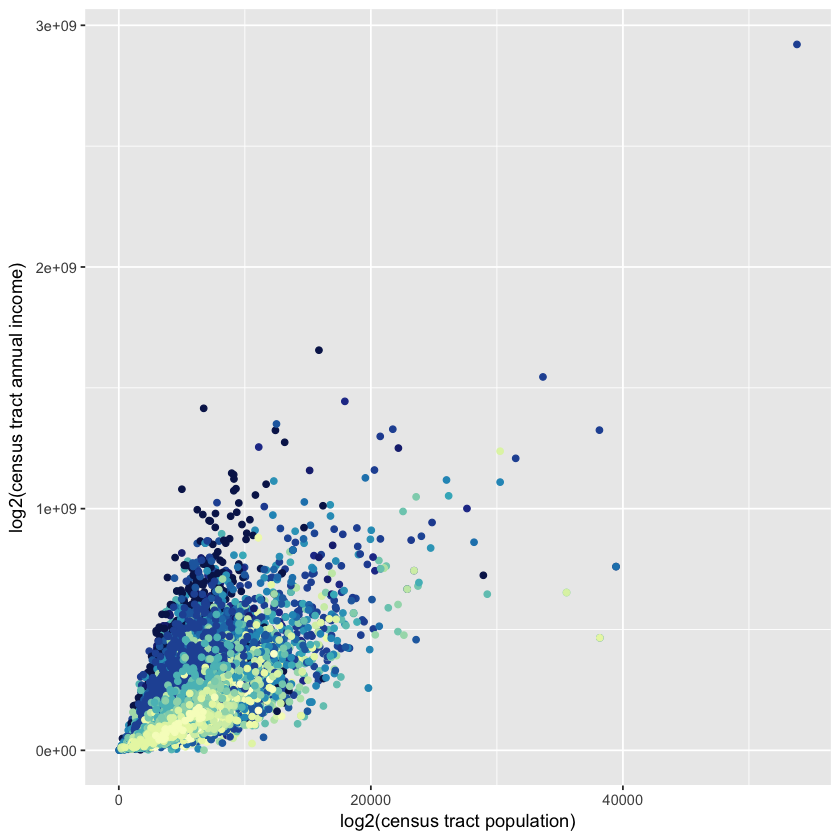

In [170]:
#aggregate CT info by MSA
sums=aggregate(list(ctmsa$ct.population,ctmsa$ct.totaldollars),by=list(ctmsa$msa,ctmsa$msa.population,ctmsa$msa.totaldollars),FUN=sum)
colnames(sums)=c('msa','population','totaldollars','population.ct','totaldollars.ct')
sumsMetro=subset(sums,sums$population.ct>100000) #take out micropolitan areas
colnames(sumsMetro)=c('msa','pop.census','dollars.census','pop.sum','dollars.sum')
ctmsa.df=merge(ctmsa,sumsMetro,by='msa')

#calculate "boost": CT dollars over expected CT dollars
ctmsa.df$boost=ctmsa.df$ct.totaldollars/((ctmsa.df$ct.population/ctmsa.df$pop.sum)*ctmsa.df$dollars.sum)
boost=ctmsa.df[,c('boost','ct')]
write.csv(boost,'boost.csv')
#smallboost=subset(ctmsa.df,log2(ctmsa.df$boost)>-3)
library(ggplot2)
#qplot(log2(smallboost$boost))
#ggsave('~/Desktop/graphs/finalpres/boosthist.png')

library(RColorBrewer)
colfunc <- colorRampPalette(brewer.pal(9,"YlGnBu"))(9)
qplot((ctmsa.df$ct.population),(ctmsa.df$ct.totaldollars),color=log2(ctmsa.df$pop.sum))+ scale_color_gradientn(colours = (colfunc),guide=FALSE) + labs(colour='log2(MSA population)',x='log2(census tract population)',y='log2(census tract annual income)')#+
#coord_cartesian(xlim = c(3, 11),ylim=c(12.5,22.5)) 
#ggsave('~/Desktop/graphs/finalpres/allcts.png')
#dev.off()



library(rgeos)
library(maptools)
library(RColorBrewer)
#create color palette 
colfunc2 <- colorRampPalette(brewer.pal(9,'YlGnBu'))(9)


In [6]:
#FLAG
# imin=min(log2(ctmsa.df$ct.population))
# imax=max(log2(ctmsa.df$ct.population))
# jmin=min(log2(ctmsa.df$ct.totaldollars))
# jmax=max(log2(ctmsa.df$ct.totaldollars))
# delta=.08
# i=imin
# blankdf=data.frame(x=NA,y=NA,i=NA,j=NA,msasize=NA,cts=NA)
# while(i+delta<imax){
#     df_bin=subset(ctmsa.df,log22(ctmsa.df$ct.population)>=i & log2(ctmsa.df$ct.population)<i+delta)
#     j=jmin
#     while(j+delta<jmax){
#         df_bin_bin=subset(df_bin,log2(df_bin$ct.totaldollars)>=j & log2(df_bin$ct.totaldollars)<j+delta)
#         #print(head(df_bin_bin))
#         x=mean(log2(df_bin_bin$ct.population))
#         y=mean(log2(df_bin_bin$ct.totaldollars))
#         msasize=mean(log2(df_bin_bin$msa.population))
#         cts=nrow(df_bin_bin)
#         blankdf=rbind(blankdf,c(x,y,i,j,msasize,cts))
#         j=j+delta
#     }
#     i=i+delta
# }
# qplot(blankdf$x,blankdf$y,color=blankdf$msasize)+scale_color_gradientn(colors=(colfunc2),guide=FALSE)+ labs(colour='log22(MSA population)',x='log22(census tract population)',y='log22(census tract annual income)')#+
# # #coord_cartesian(xlim = c(3, 11),ylim=c(12.5,22.5)) 
# #ggsave('~/Desktop/graphs/finalpres/binnedctpop_income.png')
# dev.off()

ERROR: Error in log22(ctmsa.df$ct.population): could not find function "log22"


In [ ]:
#FLAG
# blankdf2=subset(blankdf,blankdf$cts<20 & blankdf$cts>0)
# hist(blankdf2$cts)

Warning message:
“use rgdal::readOGR or sf::st_read”Warning message:
“use rgdal::readOGR or sf::st_read”

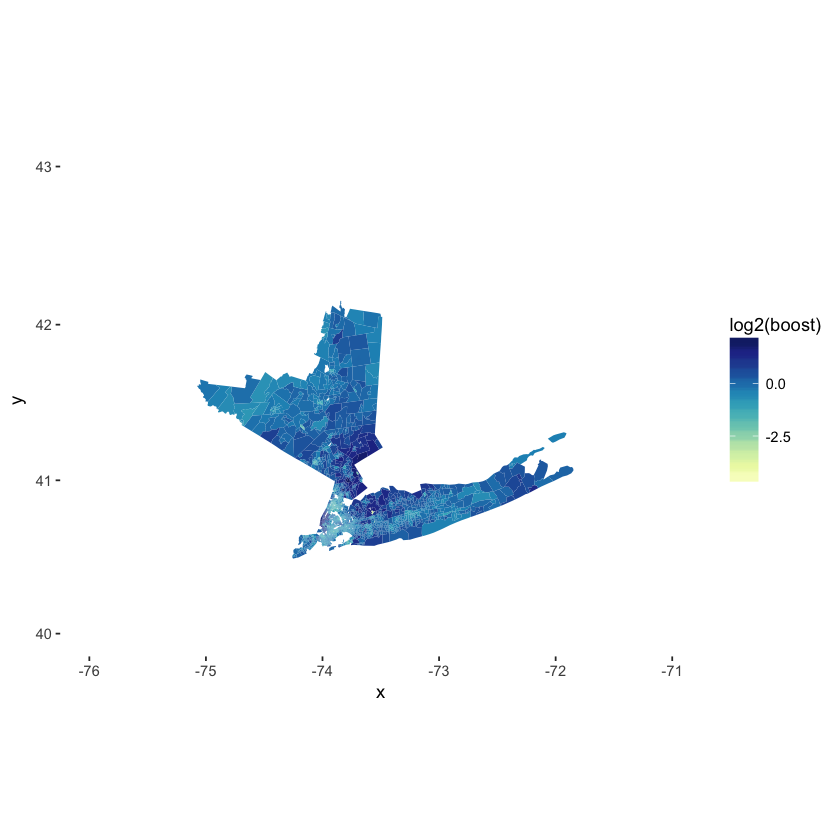

In [171]:
#create graphic of NYC boost distribution
idkey=ct_shp
ctmsa.df2=merge(ctmsa.df,idkey,by.x='ct',by.y='GEOID')
ctmsa.df.NYC=subset(ctmsa.df,ctmsa.df$msa==35620)

shp = readShapeSpatial('~/CTScalingFiles/tl_2016_36_tract/tl_2016_36_tract.shp')
shp <- fortify(shp, region = "GEOID")

ggplot() + geom_map(data = ctmsa.df.NYC, aes(map_id = ct, fill = log2(boost)),map = shp) + expand_limits(x = shp$long, y = shp$lat) + scale_fill_gradientn(colors=colfunc2,na.value='white') + coord_fixed(ratio = 1) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_blank())+scale_x_continuous(limits = c(-76, -71))+
scale_y_continuous(limits = c(40, 43))+coord_map()
#ggsave('~/Desktop/graphs/finalpres/boostNYC.png')
#dev.off()
#ggsave('~/Desktop/graphs/finalpres/boostNYC.png')


msa   ct         ct.totalworkers ct.meandollars ct.totaldollars
34678 31080 6037501803 2015             33129          66754935      
34679 31080 6037237720 1059             25426          26926134      
34680 31080 6059099903 2939             52109         153148351      
34681 31080 6037137302 2375             92894         220623250      
34682 31080 6059087901 1738             43307          75267566      
34683 31080 6059021912 2265            116435         263725275      
      ct.population msa.totalworkers msa.meandollars msa.totaldollars
34678 4814          6731786          63555           4.27839e+11     
34679 2989          6731786          63555           4.27839e+11     
34680 5993          6731786          63555           4.27839e+11     
34681 4520          6731786          63555           4.27839e+11     
34682 3605          6731786          63555           4.27839e+11     
34683 4485          6731786          63555           4.27839e+11     
      msa.population pop.census dollars.census pop.sum  dollars.sum  boost    
34678 13154457       13154457   4.27839e+11    13300494 431615563063 0.4273148
34679 13154457       13154457   4.27839e+11    13300494 431615563063 0.2775996
34680 13154457       13154457   4.27839e+11    13300494 431615563063 0.7874785
34681 13154457       13154457   4.27839e+11    13300494 431615563063 1.5041236
34682 13154457       13154457   4.27839e+11    13300494 431615563063 0.6433885
34683 13154457       13154457   4.27839e+11    13300494 431615563063 1.8120075
      ct2        
34678 06037501803
34679 06037237720
34680 06059099903
34681 06037137302
34682 06059087901
34683 06059021912

Warning message:
“use rgdal::readOGR or sf::st_read”Warning message:
“use rgdal::readOGR or sf::st_read”

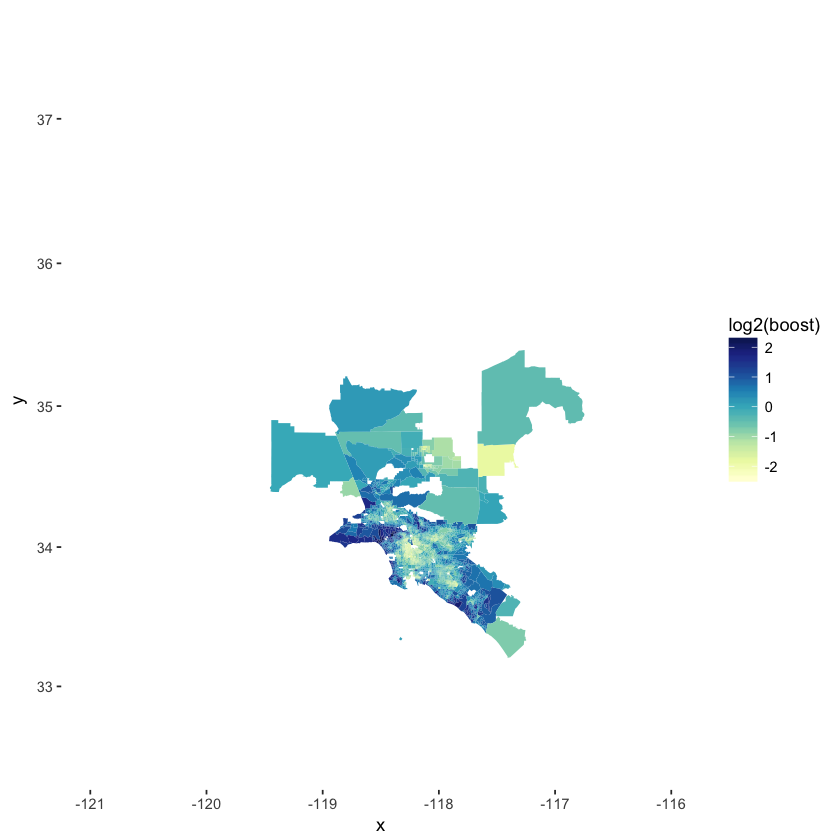

In [8]:
#create graphic of LA boost distribution
ctmsa.df.LA=subset(ctmsa.df,ctmsa.df$msa==31080)
ctmsa.df.LA$ct2=(paste(0,(ctmsa.df.LA$ct),sep=''))

head(ctmsa.df.LA)
shp = readShapeSpatial('~/CTScalingFiles/tl_2016_06_tract/tl_2016_06_tract.shp')
shp <- fortify(shp, region = as.character("GEOID"))

ggplot() + geom_map(data = ctmsa.df.LA, aes(map_id = ct2, fill = log2(boost)),map = shp) + expand_limits(x = shp$long, y = shp$lat) + scale_fill_gradientn(colors=colfunc2,na.value='white') + coord_fixed(ratio = 1) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_blank())+scale_x_continuous(limits = c(-121, -116))+
scale_y_continuous(limits = c(32.5, 37.5))+coord_map()

#ggsave('~/Desktop/graphs/finalpres/boostLA.png')
#dev.off()


### Add CT area, density

In [172]:
ct.sqmile=read.csv('ct.sqmile.csv')
head(ct.sqmile)
colnames(ct.sqmile)=c('ct','area')
ctmsa.df.density=merge(ctmsa.df,ct.sqmile,by='ct')
ctmsa.df.density$density=ctmsa.df.density$ct.population/ctmsa.df.density$area
cor.test(log2(ctmsa.df.density$ct.population),log2(ctmsa.df.density$pop.sum))

St.County.Tract Land.Area..square.miles.
1 1001020100      3.7750                  
2 1001020200      1.2905                  
3 1001020300      2.0869                  
4 1001020400      2.4657                  
5 1001020500      4.4570                  
6 1001020600      3.2463


	Pearson's product-moment correlation

data:  log2(ctmsa.df.density$ct.population) and log2(ctmsa.df.density$pop.sum)
t = 7.0429, df = 51573, p-value = 1.906e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02237340 0.03961759
sample estimates:
      cor 
0.0309978 


## Comparing quintiles: early version of deciles, see CensusTractScaling-fixed for code

## Calculating deciles

In [177]:
ctmsa.df.cut=ctmsa.df[c('msa','ct','ct.totaldollars','ct.meandollars','ct.population','pop.sum','dollars.sum')]
msas=unique(ctmsa.df.cut$msa)
ctmsa.df.cut$msa=as.numeric(as.character(ctmsa.df.cut$msa))
ctmsa.df.cut$dec=NA
n=10 #number of groups (e.g., n = 5 for quintiles)
newdf=ctmsa.df.cut[0,]
for (this.msa in msas){
     df_bin=subset(ctmsa.df.cut,ctmsa.df.cut$msa==(this.msa))
     df_bin=df_bin[order(df_bin$ct.meandollars),]
     nrow_df=nrow(df_bin)
     rownames(df_bin)=1:nrow(df_bin)
     msapop=sum(df_bin$ct.population)
     currentpop=0
     goalpop=msapop/n
     i = 1
     j.index = 1
       while (i <= n){
           while (currentpop <= goalpop*(i) & j.index <= nrow_df){
               if(currentpop + df_bin[j.index,]$ct.population>goalpop*i){
                   poptogoal=goalpop*i - currentpop
                   pctnew1ct = poptogoal/df_bin[j.index,]$ct.population
                   restpop=df_bin[j.index,]$ct.population-poptogoal
                   pctnew2ct = restpop/df_bin[j.index,]$ct.population
                   newrow=df_bin[j.index,]
                   newrow$ct.totaldollars=newrow$ct.totaldollars*pctnew2ct
                   newrow$ct.population=newrow$ct.population*pctnew2ct
                   newrow$dec=i+1
                   currentpop = currentpop + df_bin[j.index,]$ct.population
                   df_bin[j.index,]$ct.totaldollars=df_bin[j.index,]$ct.totaldollars*pctnew1ct
                   df_bin[j.index,]$ct.population=df_bin[j.index,]$ct.population*pctnew1ct
                   df_bin[j.index,]$dec=i
                   j.index=j.index+1
                   df_bin=rbind(df_bin,newrow)
               }
               else{
               df_bin[j.index,]$dec=i
               currentpop=currentpop + df_bin[j.index,]$ct.population
               #print(paste('current pop:',currentpop))
               j.index=j.index + 1 
               }
          }
          i = i+1
          }
     newdf=rbind(newdf,df_bin)
     }

head(newdf)
#write.csv(newdf,'ct.deciles.csv')

msa   ct          ct.totaldollars ct.meandollars ct.population pop.sum
1 33860 01101001200 10506610        18965          1535          438711 
2 33860 01101002202  7595846        20983          1162          438711 
3 33860 01101000600  5661657        23299          1204          438711 
4 33860 01101005603 79399224        26024          7164          438711 
5 33860 01101000300 16546474        26306          1302          438711 
6 33860 01101005902 30841727        26383          3494          438711 
  dollars.sum rent   dec
1 10416875738 255300 1  
2 10416875738  70900 1  
3 10416875738 151700 1  
4 10416875738 933600 1  
5 10416875738 171100 1  
6 10416875738 369800 1

### Test

In [178]:
#ensure that above algorithm worked correctly
#each decile should have nearly the exact same population nationally
#each decile should have the EXACT same population on a city scale

#country scale
sum = newdf %>% group_by(dec) %>% summarise(decile_pop=sum(ct.population),decile_inc=sum(ct.totaldollars))
(sum)

#city scale
test=newdf %>% group_by(msa,pop.sum,dollars.sum,dec) %>% summarise(decile_pop=sum(ct.population),decile_inc=sum(ct.totaldollars))
head(test,n=50)

dec decile_pop decile_inc  
1   1  31931963   4.928045e+11
2   2  31931963   6.107427e+11
3   3  31931963   7.052777e+11
4   4  31934130   7.837967e+11
5   5  31930001   8.622779e+11
6   6  31931759   9.460149e+11
7   7  31931963   1.048818e+12
8   8  31931963   1.170559e+12
9   9  31931963   1.364031e+12
10 10  31931963   1.839807e+12

msa   pop.sum dollars.sum dec decile_pop decile_inc
1  10140 102471   2330928380  1  10247.1     174898662
2  10140 102471   2330928380  2  10247.1     170085026
3  10140 102471   2330928380  3  10247.1     187145622
4  10140 102471   2330928380  4  10247.1     213159084
5  10140 102471   2330928380  5  10247.1     204729515
6  10140 102471   2330928380  6  10247.1     220475623
7  10140 102471   2330928380  7  10247.1     241555493
8  10140 102471   2330928380  8  10247.1     221980414
9  10140 102471   2330928380  9  10247.1     287352777
10 10140 102471   2330928380 10  10247.1     409546164
11 10180 182130   4320857676  1  18213.0     298287854
12 10180 182130   4320857676  2  18213.0     330421972
13 10180 182130   4320857676  3  18213.0     356272389
14 10180 182130   4320857676  4  18213.0     368493991
15 10180 182130   4320857676  5  18213.0     419405215
16 10180 182130   4320857676  6  18213.0     437868579
17 10180 182130   4320857676  7  18213.0     443796596
18 10180 182130   4320857676  8  18213.0     486459608
19 10180 182130   4320857676  9  18213.0     570159744
20 10180 182130   4320857676 10  18213.0     609691729
21 10300 139949   3489813682  1  13994.9     225926040
22 10300 139949   3489813682  2  13994.9     265328378
23 10300 139949   3489813682  3  13994.9     277108251
24 10300 139949   3489813682  4  13994.9     294279686
25 10300 139949   3489813682  5  13994.9     336694398
26 10300 139949   3489813682  6  13994.9     353930428
27 10300 139949   3489813682  7  13994.9     375187835
28 10300 139949   3489813682  8  13994.9     440782439
29 10300 139949   3489813682  9  13994.9     454007853
30 10300 139949   3489813682 10  13994.9     466568375
31 10420 848742  26274003165  1  82482.3    1306530282
32 10420 848742  26274003165  2  82482.3    1513927459
33 10420 848742  26274003165  3  82482.3    1818585144
34 10420 848742  26274003165  4  82482.3    2027679900
35 10420 848742  26274003165  5  82482.3    2243476030
36 10420 848742  26274003165  6  82482.3    2340090859
37 10420 848742  26274003165  7  82482.3    2659826040
38 10420 848742  26274003165  8  82482.3    2979551612
39 10420 848742  26274003165  9  82482.3    3577738652
40 10420 848742  26274003165 10  82482.3    4562600266
41 10460 110863   2214377413  1  11086.3     135257732
42 10460 110863   2214377413  2  11086.3     139563687
43 10460 110863   2214377413  3  11086.3     191062884
44 10460 110863   2214377413  4  11086.3     223471019
45 10460 110863   2214377413  5  11086.3     197897153
46 10460 110863   2214377413  6  11086.3     227753420
47 10460 110863   2214377413  7  11086.3     237838657
48 10460 110863   2214377413  8  11086.3     240064022
49 10460 110863   2214377413  9  11086.3     307022881
50 10460 110863   2214377413 10  11086.3     314445958

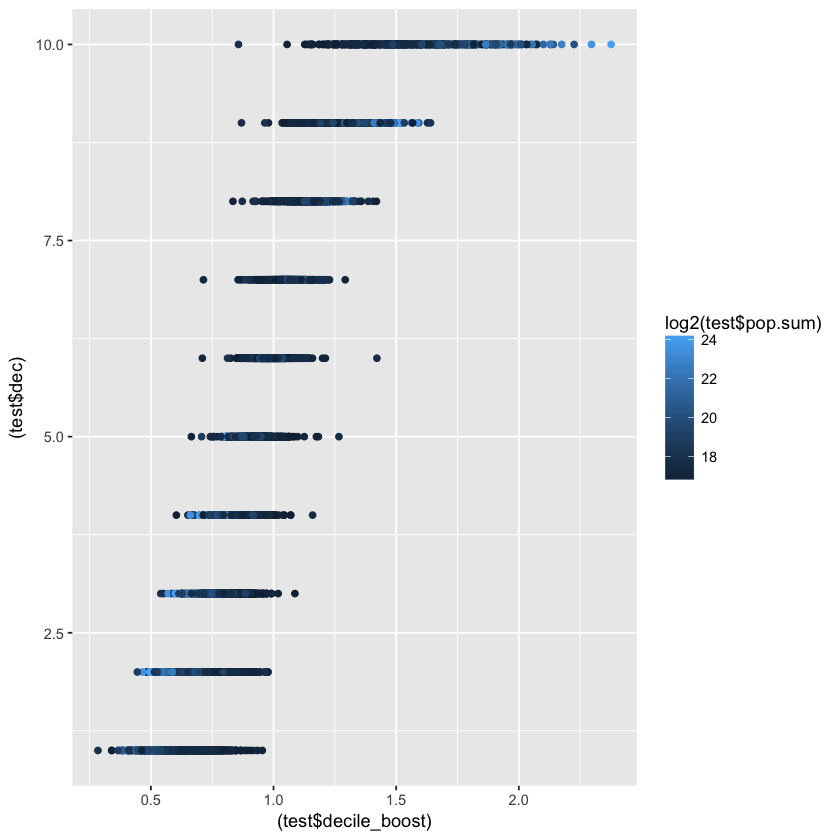

In [135]:
#look at overall boost in deciles (do higher deciles have higher boost)
test$decile_boost=test$decile_inc/((test$decile_pop/test$pop.sum)*test$dollars.sum)
qplot((test$decile_boost),(test$dec),color=log2(test$pop.sum))

In [ ]:
#FLAG
# msas=unique(ctmsa.df$msa)
# ctmsa.df$dec=NA
# newdf=ctmsa.df[0,]
# for (this.msa in msas){
# #     print(msa)
#      df_bin=subset(ctmsa.df,ctmsa.df$msa==(this.msa))
#      df_bin=df_bin[order(df_bin$ct.meandollars),]
#      rownames(df_bin)=1:nrow(df_bin)
#      msapop=mean(df_bin$pop.sum)

#      currentpop=0
#      goalpop=msapop/10
#      #print(goalpop)
#      i = 1
#      j.index = 1
#        while (i <= 10){
#            #print(i)
#            #print(goalpop)
#            while (currentpop <= goalpop*(i) & j.index <= nrow(df_bin)){
#                df_bin[j.index,]$dec=i
#                currentpop=currentpop + df_bin[j.index,]$ct.population
#                #print(paste('current pop:',currentpop))
#                j.index=j.index + 1 
               
#           }
#           i = i+1
#           }
#      newdf=rbind(newdf,df_bin)
#      }
# #newdf
# #goalpop
# head(df_bin)

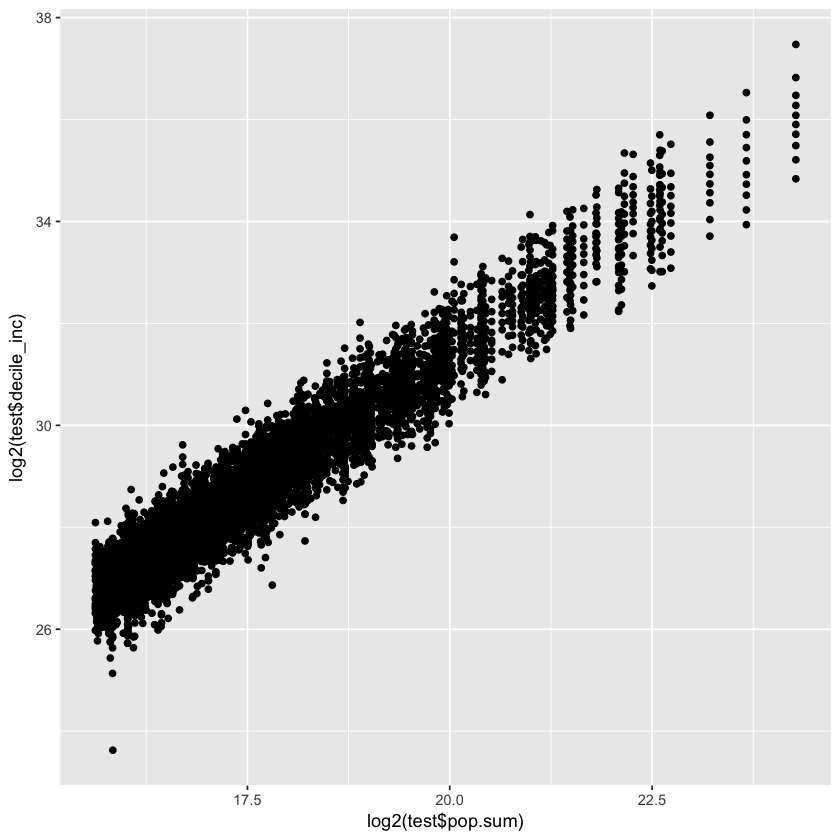

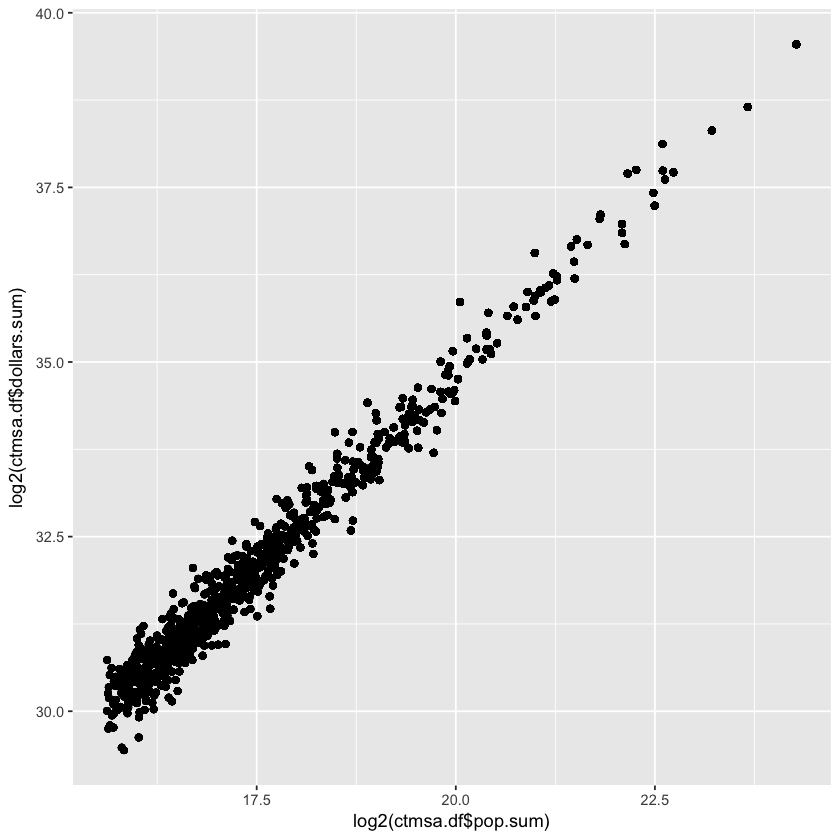

In [18]:
#plot deciles in the same way we plotted original city income/pop
#basically take original graph and break it out into deciles

qplot(log2(ctmsa.df$pop.sum),log2(ctmsa.df$dollars.sum))
qplot(log2(test$pop.sum),log2(test$decile_inc))
#ggsave('~/Desktop/graphs/finalpres/lilcitymsa.png')
#dev.off()

### Expected Decile Scale vs. Actual Decile Scale

In [136]:
#break deciles into seperate dataframes
ctmsa.1.pop=subset(test,test$dec==1)
ctmsa.2.pop=subset(test,test$dec==2)
ctmsa.3.pop=subset(test,test$dec==3)
ctmsa.4.pop=subset(test,test$dec==4)
ctmsa.5.pop=subset(test,test$dec==5)
ctmsa.6.pop=subset(test,test$dec==6)
ctmsa.7.pop=subset(test,test$dec==7)
ctmsa.8.pop=subset(test,test$dec==8)
ctmsa.9.pop=subset(test,test$dec==9)
ctmsa.10.pop=subset(test,test$dec==10)

#if you broke into more than 10 groups (n = 10+)
# ctmsa.11.pop=subset(test,test$dec==11)
# ctmsa.12.pop=subset(test,test$dec==12)
# ctmsa.13.pop=subset(test,test$dec==13)
# ctmsa.14.pop=subset(test,test$dec==14)
# ctmsa.15.pop=subset(test,test$dec==15)
# ctmsa.16.pop=subset(test,test$dec==16)
# ctmsa.17.pop=subset(test,test$dec==17)
# ctmsa.18.pop=subset(test,test$dec==18)
# ctmsa.19.pop=subset(test,test$dec==19)
# ctmsa.20.pop=subset(test,test$dec==20)

In [137]:
#create linear models for each decile
lm1.pop=summary(lm(log2(ctmsa.1.pop$decile_inc)~log2(ctmsa.1.pop$pop.sum)))
lm2.pop=summary(lm(log2(ctmsa.2.pop$decile_inc)~log2(ctmsa.2.pop$pop.sum)))
lm3.pop=summary(lm(log2(ctmsa.3.pop$decile_inc)~log2(ctmsa.3.pop$pop.sum)))
lm4.pop=summary(lm(log2(ctmsa.4.pop$decile_inc)~log2(ctmsa.4.pop$pop.sum)))
lm5.pop=summary(lm(log2(ctmsa.5.pop$decile_inc)~log2(ctmsa.5.pop$pop.sum)))
lm6.pop=summary(lm(log2(ctmsa.6.pop$decile_inc)~log2(ctmsa.6.pop$pop.sum)))
lm7.pop=summary(lm(log2(ctmsa.7.pop$decile_inc)~log2(ctmsa.7.pop$pop.sum)))
lm8.pop=summary(lm(log2(ctmsa.8.pop$decile_inc)~log2(ctmsa.8.pop$pop.sum)))
lm9.pop=summary(lm(log2(ctmsa.9.pop$decile_inc)~log2(ctmsa.9.pop$pop.sum)))
lm10.pop=summary(lm(log2(ctmsa.10.pop$decile_inc)~log2(ctmsa.10.pop$pop.sum)))
# lm11.pop=summary(lm(log2(ctmsa.11.pop$decile_inc)~log2(ctmsa.11.pop$pop.sum)))
# lm12.pop=summary(lm(log2(ctmsa.12.pop$decile_inc)~log2(ctmsa.12.pop$pop.sum)))
# lm13.pop=summary(lm(log2(ctmsa.13.pop$decile_inc)~log2(ctmsa.13.pop$pop.sum)))
# lm14.pop=summary(lm(log2(ctmsa.14.pop$decile_inc)~log2(ctmsa.14.pop$pop.sum)))
# lm15.pop=summary(lm(log2(ctmsa.15.pop$decile_inc)~log2(ctmsa.15.pop$pop.sum)))
# lm16.pop=summary(lm(log2(ctmsa.16.pop$decile_inc)~log2(ctmsa.16.pop$pop.sum)))
# lm17.pop=summary(lm(log2(ctmsa.17.pop$decile_inc)~log2(ctmsa.17.pop$pop.sum)))
# lm18.pop=summary(lm(log2(ctmsa.18.pop$decile_inc)~log2(ctmsa.18.pop$pop.sum)))
# lm19.pop=summary(lm(log2(ctmsa.19.pop$decile_inc)~log2(ctmsa.19.pop$pop.sum)))
# lm20.pop=summary(lm(log2(ctmsa.20.pop$decile_inc)~log2(ctmsa.20.pop$pop.sum)))

#create linar models for each decile, expected scaling (fix scaling coefficient at the all decile scaling coefficient)
lm1.exp=summary(lm(I(log2(ctmsa.1.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.1.pop$pop.sum)))~1))
lm2.exp=summary(lm(I(log2(ctmsa.2.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.2.pop$pop.sum)))~1))
lm3.exp=summary(lm(I(log2(ctmsa.3.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.3.pop$pop.sum)))~1))
lm4.exp=summary(lm(I(log2(ctmsa.4.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.4.pop$pop.sum)))~1))
lm5.exp=summary(lm(I(log2(ctmsa.5.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.5.pop$pop.sum)))~1))
lm6.exp=summary(lm(I(log2(ctmsa.6.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.6.pop$pop.sum)))~1))
lm7.exp=summary(lm(I(log2(ctmsa.7.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.7.pop$pop.sum)))~1))
lm8.exp=summary(lm(I(log2(ctmsa.8.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.8.pop$pop.sum)))~1))
lm9.exp=summary(lm(I(log2(ctmsa.9.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.9.pop$pop.sum)))~1))
lm10.exp=summary(lm(I(log2(ctmsa.10.pop$decile_inc)-I(lm.alldec.b1*log2(ctmsa.10.pop$pop.sum)))~1))

In [138]:
#fit every decile (10 x ~300 of them) to a line
lm.alldec=summary(lm(log2(test$decile_inc)~log2(test$pop.sum)))
lm.alldec.b0=lm.alldec$coefficients[1]
lm.alldec.b1=lm.alldec$coefficients[2]

colfunc <- colorRampPalette(brewer.pal(9,"YlGnBu"))(10) #color palette

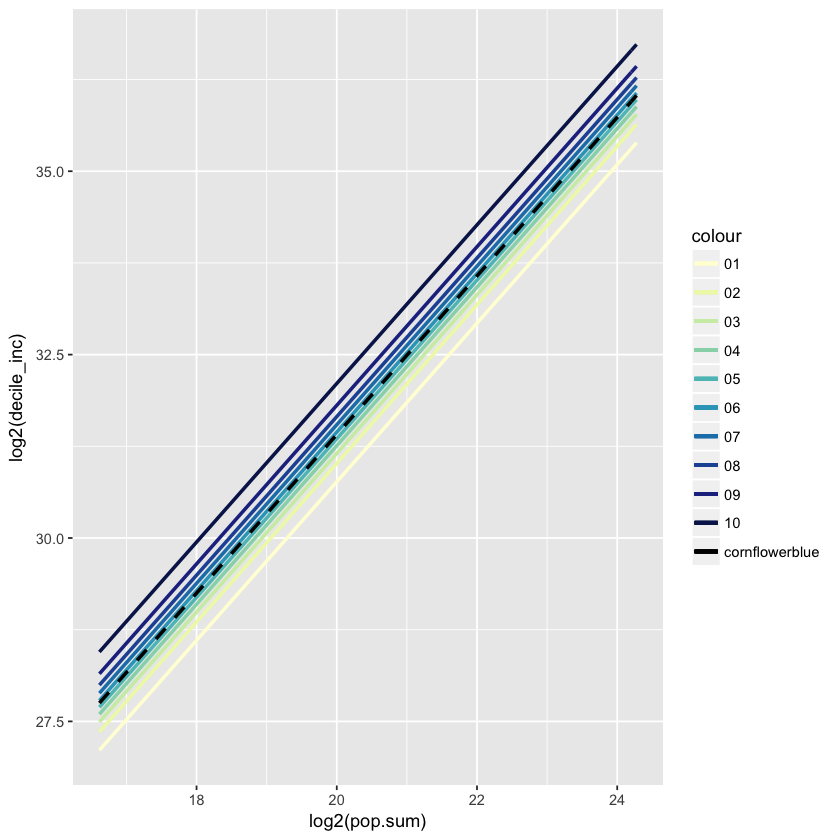

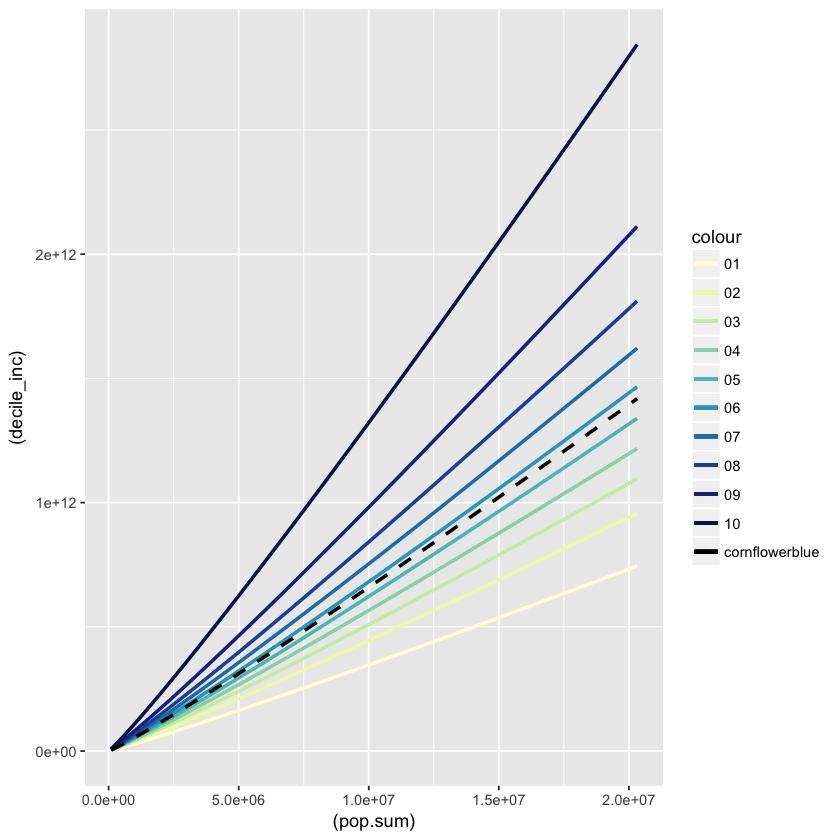

In [139]:
#expected scaling plot
#qplot(log2(test$pop.sum),log2(test$decile_inc))+
ggplot(data=test,aes(log2(pop.sum),log2(decile_inc)))+
stat_function(fun=function(x) (lm1.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='01'))+
stat_function(fun=function(x) (lm2.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='02'))+
stat_function(fun=function(x) (lm3.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='03'))+
stat_function(fun=function(x) (lm4.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='04'))+
stat_function(fun=function(x) (lm5.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='05'))+
stat_function(fun=function(x) (lm6.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='06'))+
stat_function(fun=function(x) (lm7.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='07'))+
stat_function(fun=function(x) (lm8.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='08'))+
stat_function(fun=function(x) (lm9.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='09'))+
stat_function(fun=function(x) (lm10.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='10'))+
stat_function(fun=function(x) (lm.alldec$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='cornflowerblue'),linetype='dashed')+
scale_color_manual(values=c(colfunc,'black'))

#expected scaling plot, unlogged
ggplot(data=test,aes((pop.sum),(decile_inc)))+
stat_function(fun=function(x) (exp(lm1.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='01'))+
stat_function(fun=function(x) (exp(lm2.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='02'))+
stat_function(fun=function(x) (exp(lm3.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='03'))+
stat_function(fun=function(x) (exp(lm4.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='04'))+
stat_function(fun=function(x) (exp(lm5.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='05'))+
stat_function(fun=function(x) (exp(lm6.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='06'))+
stat_function(fun=function(x) (exp(lm7.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='07'))+
stat_function(fun=function(x) (exp(lm8.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='08'))+
stat_function(fun=function(x) (exp(lm9.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='09'))+
stat_function(fun=function(x) (exp(lm10.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='10'))+
stat_function(fun=function(x) (exp(lm.alldec$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='cornflowerblue'),linetype='dashed')+
scale_color_manual(values=c(colfunc,'black'))


### Actual Decile Scale

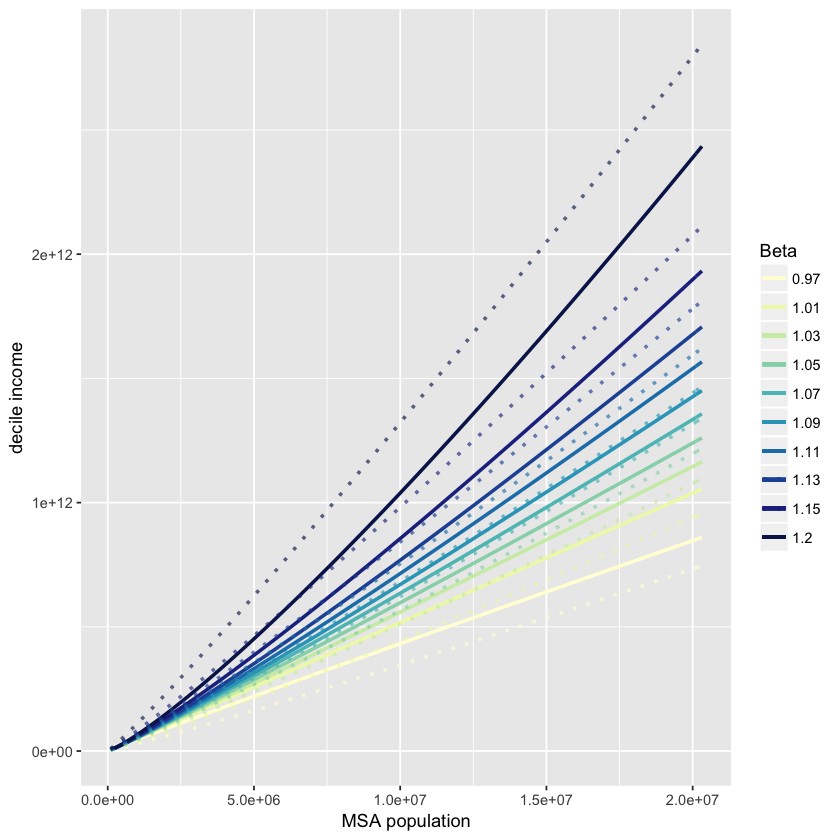

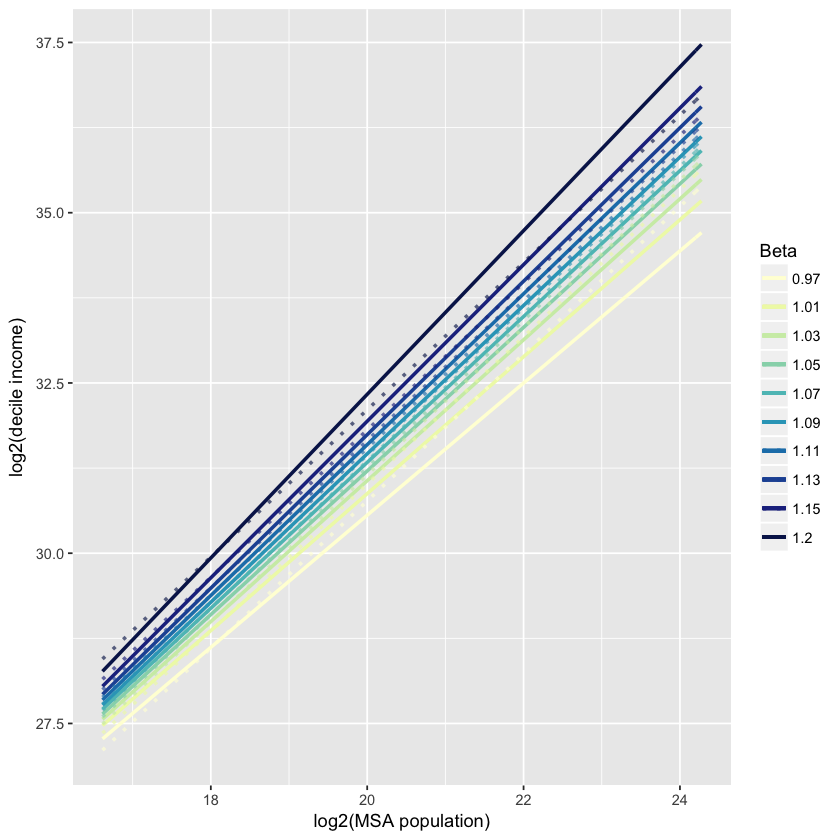

In [142]:
n=10
colfunc <- colorRampPalette(brewer.pal(9,"YlGnBu"))(n)
a=.65

#actual scaling + expected scaling
ggplot(data=test,aes((pop.sum),(dollars.sum))) +
stat_function(fun = function(x)(exp(lm1.pop$coefficients[1]) * (x)^lm1.pop$coefficients[2]),size=1,aes(colour=paste('01'))) + 
stat_function(fun = function(x)(exp(lm2.pop$coefficients[1]) * (x)^lm2.pop$coefficients[2]),size=1,aes(colour=paste('02'))) + 
stat_function(fun = function(x)(exp(lm3.pop$coefficients[1]) * (x)^lm3.pop$coefficients[2]),size=1,aes(colour=paste('03'))) + 
stat_function(fun = function(x)(exp(lm4.pop$coefficients[1]) * (x)^lm4.pop$coefficients[2]),size=1,aes(colour=paste('04'))) + 
stat_function(fun = function(x)(exp(lm5.pop$coefficients[1]) * (x)^lm5.pop$coefficients[2]),size=1,aes(colour=paste('05'))) + 
stat_function(fun = function(x)(exp(lm6.pop$coefficients[1]) * (x)^lm6.pop$coefficients[2]),size=1,aes(colour=paste('06'))) + 
stat_function(fun = function(x)(exp(lm7.pop$coefficients[1]) * (x)^lm7.pop$coefficients[2]),size=1,aes(colour=paste('07'))) + 
stat_function(fun = function(x)(exp(lm8.pop$coefficients[1]) * (x)^lm8.pop$coefficients[2]),size=1,aes(colour=paste('08'))) + 
stat_function(fun = function(x)(exp(lm9.pop$coefficients[1]) * (x)^lm9.pop$coefficients[2]),size=1,aes(colour=paste('09'))) + 
stat_function(fun = function(x)(exp(lm10.pop$coefficients[1]) * (x)^lm10.pop$coefficients[2]),size=1,aes(colour=paste('10'))) +
# stat_function(fun = function(x)(exp(lm11.pop$coefficients[1]) * (x)^lm11.pop$coefficients[2]),size=1,aes(colour=paste('11: 0-10%'))) + 
# stat_function(fun = function(x)(exp(lm12.pop$coefficients[1]) * (x)^lm12.pop$coefficients[2]),size=1,aes(colour=paste('12: 10-20%'))) + 
# stat_function(fun = function(x)(exp(lm13.pop$coefficients[1]) * (x)^lm13.pop$coefficients[2]),size=1,aes(colour=paste('13: 20-30%'))) + 
# stat_function(fun = function(x)(exp(lm14.pop$coefficients[1]) * (x)^lm14.pop$coefficients[2]),size=1,aes(colour=paste('14: 30-40%'))) + 
# stat_function(fun = function(x)(exp(lm15.pop$coefficients[1]) * (x)^lm15.pop$coefficients[2]),size=1,aes(colour=paste('15: 40-50%'))) + 
# stat_function(fun = function(x)(exp(lm16.pop$coefficients[1]) * (x)^lm16.pop$coefficients[2]),size=1,aes(colour=paste('16: 50-60%'))) + 
# stat_function(fun = function(x)(exp(lm17.pop$coefficients[1]) * (x)^lm17.pop$coefficients[2]),size=1,aes(colour=paste('17: 60-70%'))) + 
# stat_function(fun = function(x)(exp(lm18.pop$coefficients[1]) * (x)^lm18.pop$coefficients[2]),size=1,aes(colour=paste('18: 70-80%'))) + 
# stat_function(fun = function(x)(exp(lm19.pop$coefficients[1]) * (x)^lm19.pop$coefficients[2]),size=1,aes(colour=paste('19: 80-90%'))) + 
# stat_function(fun = function(x)(exp(lm20.pop$coefficients[1]) * (x)^lm20.pop$coefficients[2]),size=1,aes(colour=paste('20: 90-100%'))) +
stat_function(fun=function(x) (exp(lm1.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='01'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm2.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='02'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm3.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='03'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm4.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='04'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm5.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='05'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm6.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='06'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm7.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='07'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm8.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='08'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm9.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='09'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (exp(lm10.exp$coefficients[1]) * x^lm.alldec$coefficients[2]),size=1,aes(color='10'),alpha=a,linetype='dotted')+
    scale_color_manual(values=c(colfunc),labels=round(coeffs,digits=2)) +
    labs(color='Beta',x='MSA population',y='decile income')
#ggsave(paste('~/Desktop/graphs/finalpres/deciles',n,'.png',sep=''))
   
#actual scaling + expected scaling, unlogged
ggplot(data=test,aes(log2(pop.sum),log2(dollars.sum))) +
stat_function(fun = function(x)(lm1.pop$coefficients[1] + (x)*lm1.pop$coefficients[2]),size=1,aes(colour=paste('01'))) + 
stat_function(fun = function(x)((lm2.pop$coefficients[1]) + (x)*lm2.pop$coefficients[2]),size=1,aes(colour=paste('02'))) + 
stat_function(fun = function(x)((lm3.pop$coefficients[1]) + (x)*lm3.pop$coefficients[2]),size=1,aes(colour=paste('03'))) + 
stat_function(fun = function(x)((lm4.pop$coefficients[1]) + (x)*lm4.pop$coefficients[2]),size=1,aes(colour=paste('04'))) + 
stat_function(fun = function(x)((lm5.pop$coefficients[1]) + (x)*lm5.pop$coefficients[2]),size=1,aes(colour=paste('05'))) + 
stat_function(fun = function(x)((lm6.pop$coefficients[1]) + (x)*lm6.pop$coefficients[2]),size=1,aes(colour=paste('06'))) + 
stat_function(fun = function(x)((lm7.pop$coefficients[1]) + (x)*lm7.pop$coefficients[2]),size=1,aes(colour=paste('07'))) + 
stat_function(fun = function(x)((lm8.pop$coefficients[1]) + (x)*lm8.pop$coefficients[2]),size=1,aes(colour=paste('08'))) + 
stat_function(fun = function(x)((lm9.pop$coefficients[1]) + (x)*lm9.pop$coefficients[2]),size=1,aes(colour=paste('09'))) + 
stat_function(fun = function(x)((lm10.pop$coefficients[1]) + (x)*lm10.pop$coefficients[2]),size=1,aes(colour=paste('10'))) + 
# stat_function(fun = function(x)(lm11.pop$coefficients[1] + (x)*lm11.pop$coefficients[2]),size=1,aes(colour=paste('11: 0-10%'))) + 
# stat_function(fun = function(x)((lm12.pop$coefficients[1]) + (x)*lm12.pop$coefficients[2]),size=1,aes(colour=paste('12: 10-20%'))) + 
# stat_function(fun = function(x)((lm13.pop$coefficients[1]) + (x)*lm13.pop$coefficients[2]),size=1,aes(colour=paste('13: 20-30%'))) + 
# stat_function(fun = function(x)((lm14.pop$coefficients[1]) + (x)*lm14.pop$coefficients[2]),size=1,aes(colour=paste('14: 30-40%'))) + 
# stat_function(fun = function(x)((lm15.pop$coefficients[1]) + (x)*lm15.pop$coefficients[2]),size=1,aes(colour=paste('15: 40-50%'))) + 
# stat_function(fun = function(x)((lm16.pop$coefficients[1]) + (x)*lm16.pop$coefficients[2]),size=1,aes(colour=paste('16: 50-60%'))) + 
# stat_function(fun = function(x)((lm17.pop$coefficients[1]) + (x)*lm17.pop$coefficients[2]),size=1,aes(colour=paste('17: 60-70%'))) + 
# stat_function(fun = function(x)((lm18.pop$coefficients[1]) + (x)*lm18.pop$coefficients[2]),size=1,aes(colour=paste('18: 70-80%'))) + 
# stat_function(fun = function(x)((lm19.pop$coefficients[1]) + (x)*lm19.pop$coefficients[2]),size=1,aes(colour=paste('19: 80-90%'))) + 
# stat_function(fun = function(x)((lm20.pop$coefficients[1]) + (x)*lm20.pop$coefficients[2]),size=1,aes(colour=paste('20: 90-100%'))) +    
stat_function(fun=function(x) (lm1.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='01'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm2.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='02'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm3.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='03'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm4.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='04'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm5.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='05'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm6.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='06'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm7.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='07'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm8.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='08'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm9.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='09'),alpha=a,linetype='dotted')+
stat_function(fun=function(x) (lm10.exp$coefficients[1]) + x*lm.alldec$coefficients[2],size=1,aes(color='10'),alpha=a,linetype='dotted')+
scale_color_manual(values=c(colfunc,'black'),labels=round(coeffs,digits=2)) +
    labs(color='Beta',x='log2(MSA population)',y='log2(decile income)')
#ggsave(paste('~/Desktop/graphs/finalpres/decilesunlog2ged',n,'.png',sep=''))
#dev.off()
    

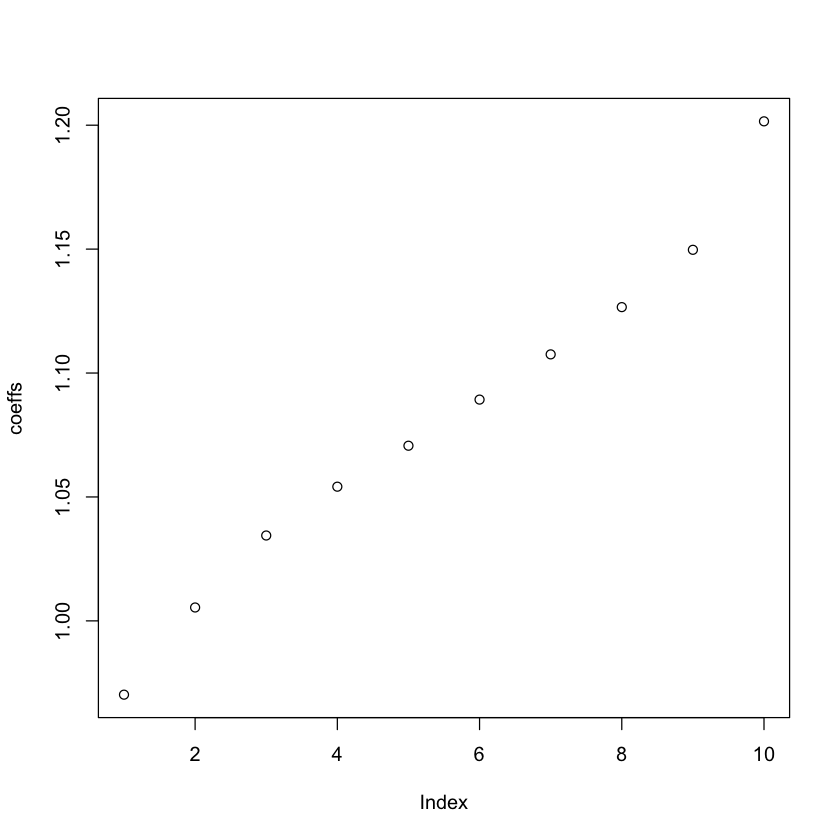

In [141]:
#actual scaling coefficients
coeffs=c(lm1.pop$coefficients[2],lm2.pop$coefficients[2],lm3.pop$coefficients[2],lm4.pop$coefficients[2],lm5.pop$coefficients[2],lm6.pop$coefficients[2],lm7.pop$coefficients[2],lm8.pop$coefficients[2],lm9.pop$coefficients[2],lm10.pop$coefficients[2])#,lm11.pop$coefficients[2],lm12.pop$coefficients[2],lm13.pop$coefficients[2],lm14.pop$coefficients[2],lm15.pop$coefficients[2],lm16.pop$coefficients[2],lm17.pop$coefficients[2],lm18.pop$coefficients[2],lm19.pop$coefficients[2],lm20.pop$coefficients[2])
plot(coeffs)

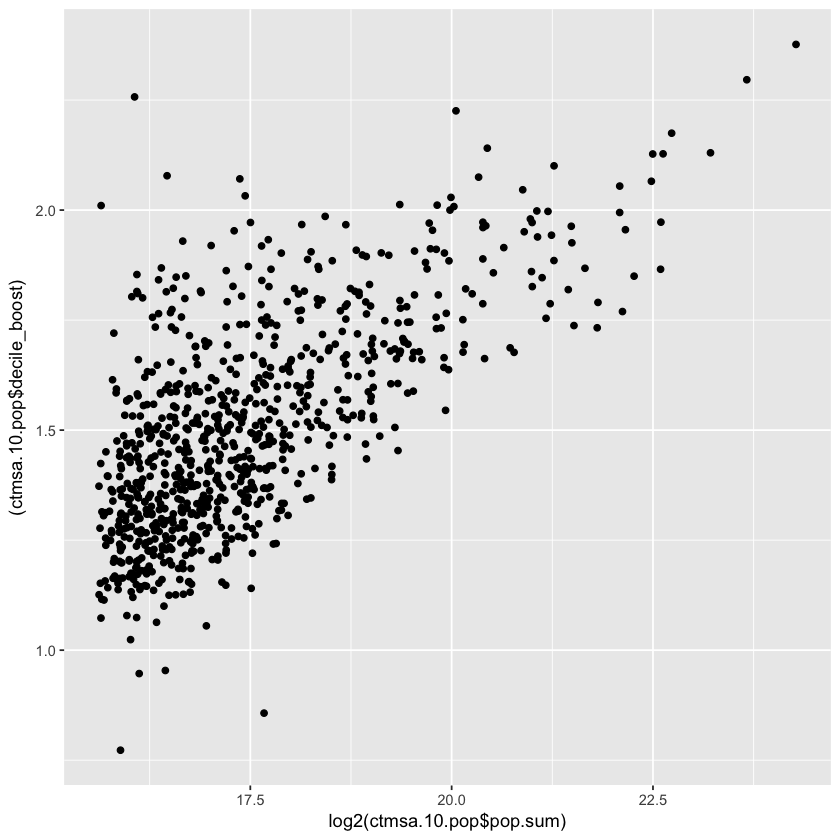

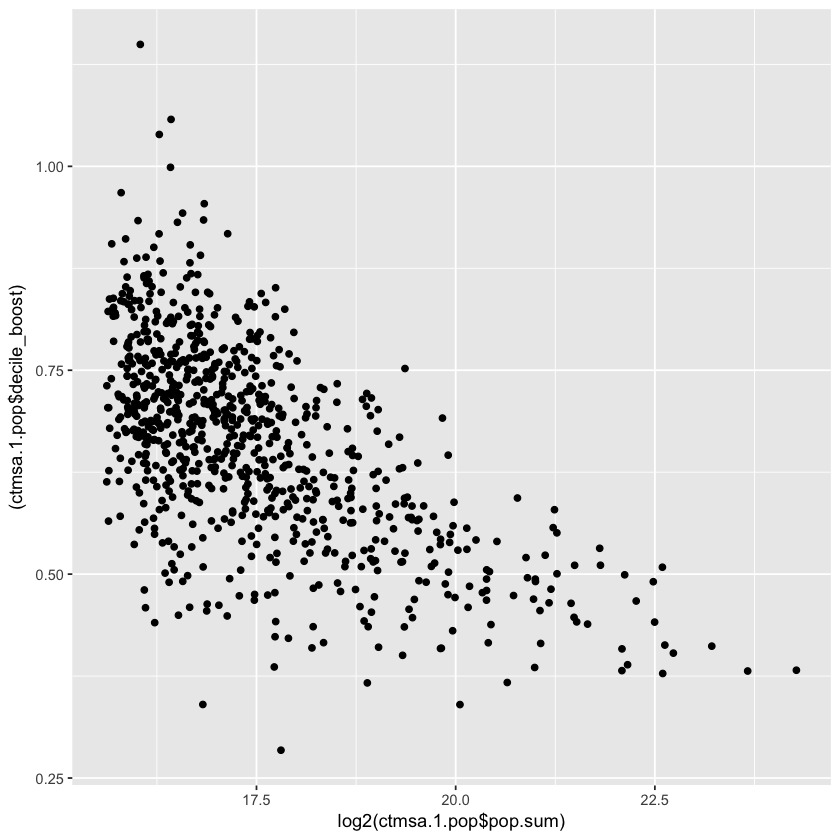

In [35]:
#boost with city size in decile 1; boost with city size in decile 10
#boost goes up with city size in decile 10; down with city size in decile 1
#the gist: they move apart
qplot(log2(ctmsa.10.pop$pop.sum),(ctmsa.10.pop$decile_boost))
qplot(log2(ctmsa.1.pop$pop.sum),(ctmsa.1.pop$decile_boost))

msa   pop.sum dollars.sum dec decile_pop decile_inc decile_boost
1 10100  60151   1701373208 1    6015.1     147028296 0.8641743   
2 10140 102471   2330928380 1   10247.1     174898662 0.7503391   
3 10180 182130   4320857676 1   18213.0     298287854 0.6903441   
4 10220  64071   1301025484 1    6407.1      90923620 0.6988612   
5 10300 139949   3489813682 1   13994.9     225926040 0.6473871   
6 10420 848742  26274003165 1   84874.2    1338577449 0.5094684

msa   pop.sum decile_diff
1 10100  60151  1.390677   
2 10140 102471  2.341620   
3 10180 182130  2.043971   
4 10220  64071  1.543372   
5 10300 139949  2.065138   
6 10420 848742  3.663088


Call:
lm(formula = log2(topbotpop_diff$decile_diff) ~ log2(topbotpop_diff$pop.sum), 
    na.action = na.omit)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9041 -0.2001 -0.0131  0.1731  1.3164 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -2.769856   0.132309  -20.93   <2e-16 ***
log2(topbotpop_diff$pop.sum)  0.227104   0.007559   30.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3212 on 830 degrees of freedom
Multiple R-squared:  0.5209,	Adjusted R-squared:  0.5204 
F-statistic: 902.6 on 1 and 830 DF,  p-value: < 2.2e-16


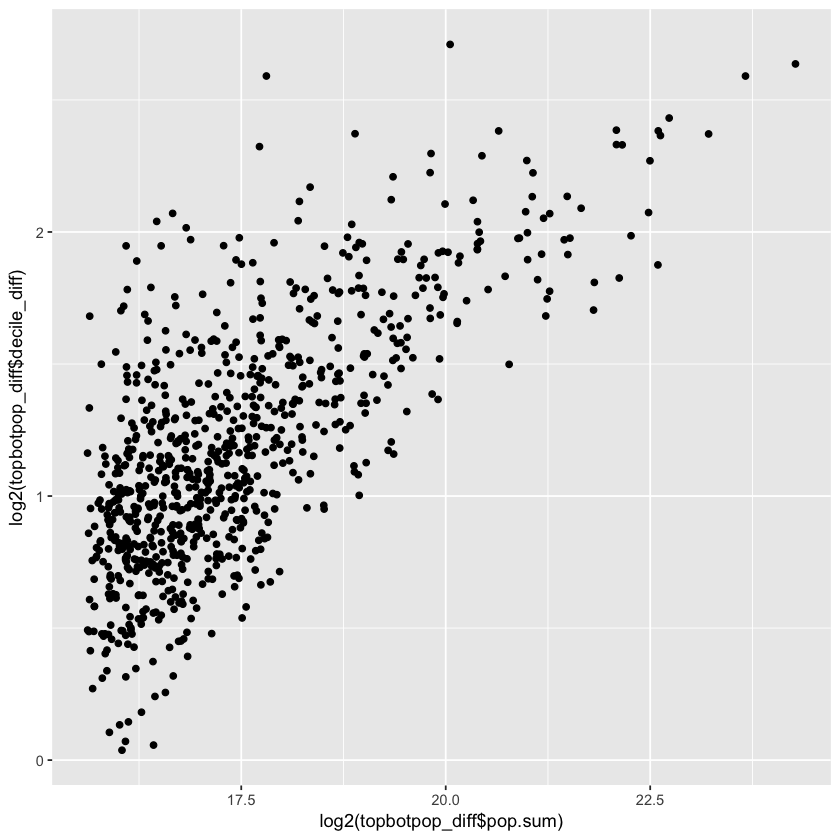

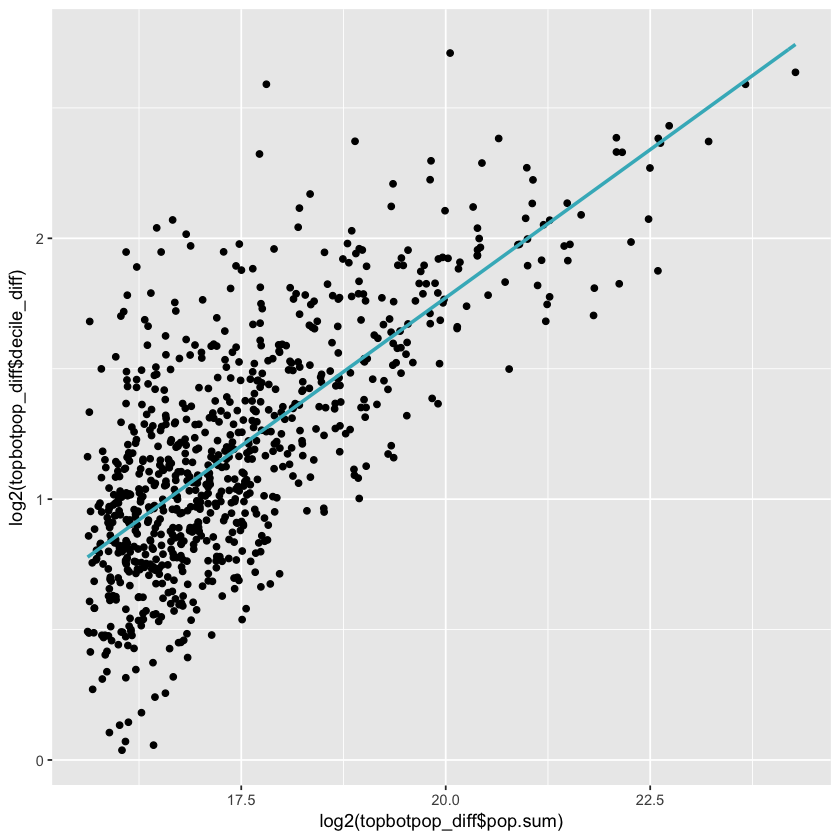

In [34]:
#FLAG
#this was problematic bc subtracting two logs? right? or log of a difference?
test2=test %>% group_by(msa,pop.sum,dollars.sum) %>% summarise(decile_diff=max(decile_inc)-min(decile_inc))
#head(test2)
topbotpop=rbind(ctmsa.1.pop,ctmsa.10.pop)
head(topbotpop)
topbotpop_diff=topbotpop %>% group_by(msa,pop.sum) %>% summarise(decile_diff=(max(decile_inc))/(min(decile_inc)))
head(topbotpop_diff)
qplot(log2(topbotpop_diff$pop.sum),log2(topbotpop_diff$decile_diff))
#ggsave('~/Desktop/graphs/finalpres/diffscale.png')


topbotpop_diff=na.omit(topbotpop_diff)

topbotpop_diff$decile_diff[which(topbotpop_diff$decile_diff==0)] = NA

lmdiff=summary(lm(log2(topbotpop_diff$decile_diff)~log2(topbotpop_diff$pop.sum),na.action=na.omit))
lmdiff
qplot(log2(topbotpop_diff$pop.sum),log2(topbotpop_diff$decile_diff)) + stat_function(fun=function(x) lmdiff$coefficients[1] + x*lmdiff$coefficients[2],size=1,color='#41b6c4')
#ggsave('~/Desktop/graphs/finalpres/diffscaleline.png')
#dev.off()

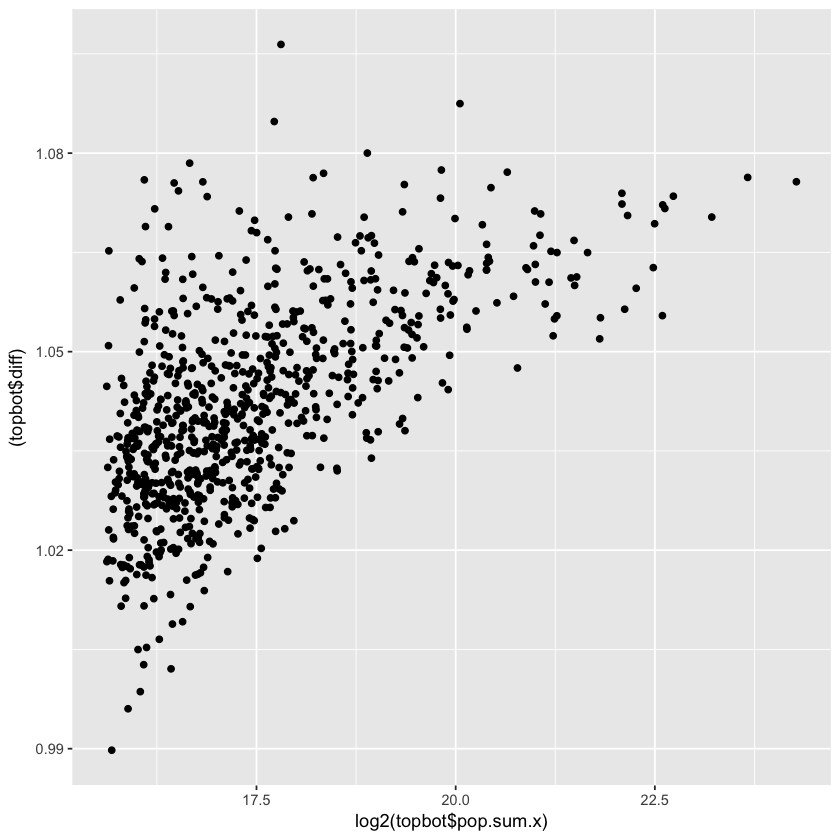


	Pearson's product-moment correlation

data:  log2(topbot$pop.sum.x) and log2(topbot$diff)
t = 21.989, df = 830, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5619226 0.6479652
sample estimates:
     cor 
0.606718 


[1] 832

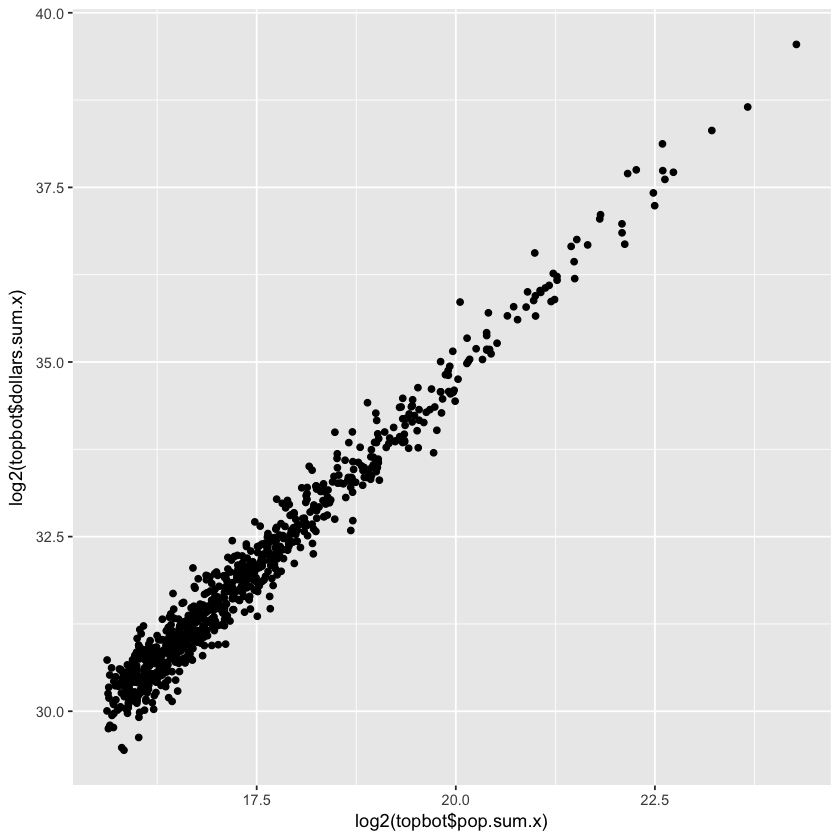

In [38]:
#FLAG
#same as above
topbot=merge(ctmsa.1.pop,ctmsa.10.pop,by='msa')
topbot$diff=log2(topbot$decile_inc.y)/log2(topbot$decile_inc.x)
qplot(log2(topbot$pop.sum.x),(topbot$diff))
qplot(log2(topbot$pop.sum.x),log2(topbot$dollars.sum.x))

#ggsave('~/Desktop/graphs/finalpres/topbotdiff.png')
#dev.off()
cor.test(log2(topbot$pop.sum.x),log2(topbot$diff))
nrow(topbot)

### Bin CTs by MSA population, look at CT income distribution for different MSA sizes

In [39]:
df=ctmsa.df

#### bins by CT population

ERROR: Error in nrow(hist_descriptions): object 'hist_descriptions' not found


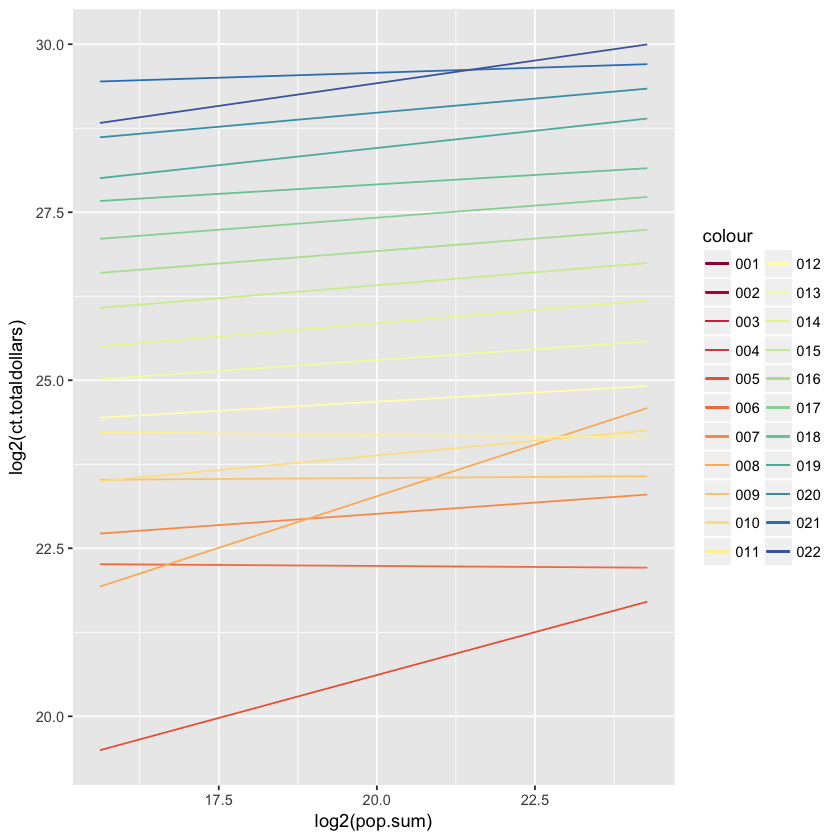

In [40]:
library(RColorBrewer)
library(entropy)
library(moments)

#bin CTs by CT population
imin = log2(min(df$ct.population))
imax = log2(max(df$ct.population))
i = imin #start at minimum
delta = .5 #step size (in log pop)
j <- ggplot(data=df, aes(log2(pop.sum),log2(ct.totaldollars))) #you're building a plot
coeff = data.frame(b0=NA,b1=NA,binmin=NA,binmax=NA) #empty table
count=1
colcount=1

while(i + delta < imax){ #step through, creating bins of log .5 from min to max
    df_bin = subset(df,log2(df$ct.population) >= i & log2(df$ct.population) < i + delta) 
    if (nrow(df_bin)>0){
        lm_sum = summary(lm(log2(df_bin$ct.totaldollars)~log2(df_bin$pop.sum))) #CT dollars against MSA size 
        newi = i + delta
        if(count<10){ #this is in order to make all the colors different, ignore it
            loop_input=paste('stat_function(fun=function(x) (', lm_sum$coefficients[1], '+', lm_sum$coefficients[2],'*x),aes(color=\'00' ,count,'\'))',sep='')
        } else if(count < 100){
            loop_input=paste('stat_function(fun=function(x) (', lm_sum$coefficients[1], '+', lm_sum$coefficients[2],'*x),aes(color=\'0' ,count,'\'))',sep='')
        } else{
            loop_input=paste('stat_function(fun=function(x) (', lm_sum$coefficients[1], '+', lm_sum$coefficients[2],'*x),aes(color=\'' ,count,'\'))',sep='')            

        }
        colcount=colcount+1
        j <- j + eval(parse(text=loop_input))

    }
    i = i + delta
    count = count + 1

}
colfunc <- colorRampPalette(brewer.pal(11,"Spectral"))(colcount)
colfunc2 <- colorRampPalette(c('cadetblue2','navy'))(colcount)

j <- j + scale_color_manual(values=colfunc)

j

CHECK THIS but i think you should see a slight (.09?) positive relationship and that's what you do see!!! should be the AX^(B-1) part

#### bins by MSA population & CT population

Warning message:
“Removed 21 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 20 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 19 rows containing missing values (geom_point).”Warning message:
“Removed 19 rows containing missing values (geom_point).”Warning message:
“Removed 25 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_point).”Warning message:
“Removed 20 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 29 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows cont

Saving 7 x 7 in image
Warning message:
“Removed 21 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 20 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 19 rows containing missing values (geom_point).”Warning message:
“Removed 19 rows containing missing values (geom_point).”Warning message:
“Removed 25 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_point).”Warning message:
“Removed 20 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 29 rows containing missing values (geom_point).”Warning message:

null device 
          1

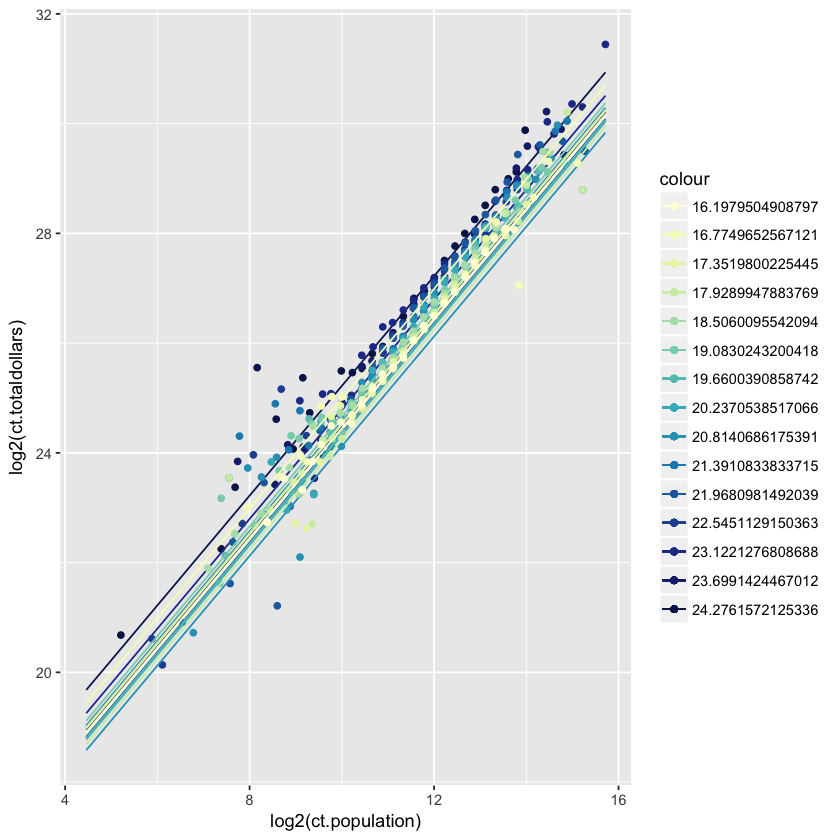

In [41]:
df=ctmsa.df
lm.all=summary(lm(log2(df$ct.totaldollars)~log2(df$ct.population))) #create lm for reference with all CTs
b1=lm.all$coefficients[2]

library(RColorBrewer)
library(entropy)
library(moments)

imin = log2(min(df$pop.sum)) #min MSA population
imax = log2(max(df$pop.sum)) #max MSA population
jmin = log2(min(df$ct.population)) #min CT population
jmax = log2(max(df$ct.population)) #min CT population

i = imax
j = jmax
jdelta = (jmax-jmin)/50 #50 CT population bins
idelta = (imax-imin)/15 #15 MSA population bins
plt <- ggplot(data=df,aes(log2(ct.population),log2(ct.totaldollars))) #base plot
blankdf=data.frame(msaPop=NA,ctPop=NA,ctDol=NA)

while(i - idelta > imin){
    df_bin = subset(df,log2(df$pop.sum) <= i & log2(df$pop.sum) > i - idelta)
    df_binsub=subset(df_bin,log2(df_bin$ct.population) <= 10 & log2(df_bin$ct.population) > 7.5)
    
    #in the fit line below, you're fixing the slope at one
    lmbin=summary(lm(I(log2(df_binsub$ct.totaldollars)-I(log2(df_binsub$ct.population)))~1))
    loop_input=paste('stat_function(fun=function(x) (', lmbin$coefficients[1], '+x),aes(color=\'' ,i,'\'))',sep='')    
    thisbindf=data.frame(msaPop=NA,ctPop=NA,ctDol=NA)
    j=jmax
        while(j - jdelta > jmin){
        df_bin_bin=subset(df_bin,log2(df_bin$ct.population) <= j & log2(df_bin$ct.population) > j - jdelta)
        meanctPop=mean(df_bin_bin$ct.population)
        meanmsaPop=mean(df_bin_bin$pop.sum)
        meanctDol=mean(df_bin_bin$ct.totaldollars)
        thisbindf=rbind(thisbindf,c(meanmsaPop,meanctPop,meanctDol))
        blankdf=rbind(blankdf,c(meanmsaPop,meanctPop,meanctDol))
        j=j-jdelta
        }
    loop_input2=paste('geom_point(data=thisbindf,aes(log2(ctPop),log2(ctDol),color=\'' ,i,'\'))',sep='')
    head(blankdf)
    head(thisbindf)
    plt <- plt  + eval(parse(text=loop_input2)) + eval(parse(text=loop_input))
    i=i-idelta
    }

colfunc <- colorRampPalette(brewer.pal(9,"YlGnBu"))(15)
plt=plt + scale_color_manual(values=colfunc) #+ coord_cartesian(xlim = c(3, 11),ylim=c(12.5,22.5))

plt
#ggsave('~/Desktop/graphs/finalpres/binnedallcts.lines.png')
#dev.off()

#### bin just by MSA size

[1] 4683
[1] 5151
[1] 5374
[1] 7435
[1] 4975
[1] 7541
[1] 4421
[1] 5813
[1] 4972
[1] 5637
[1] 4111
[1] 5763
[1] 4437
[1] 4213
[1] 2606


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

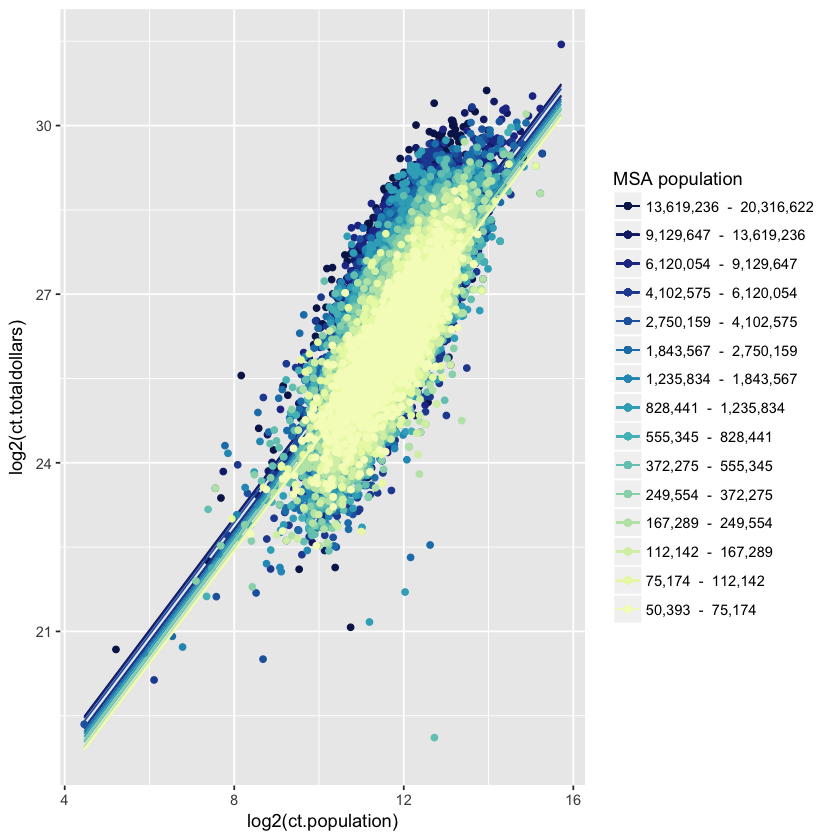

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

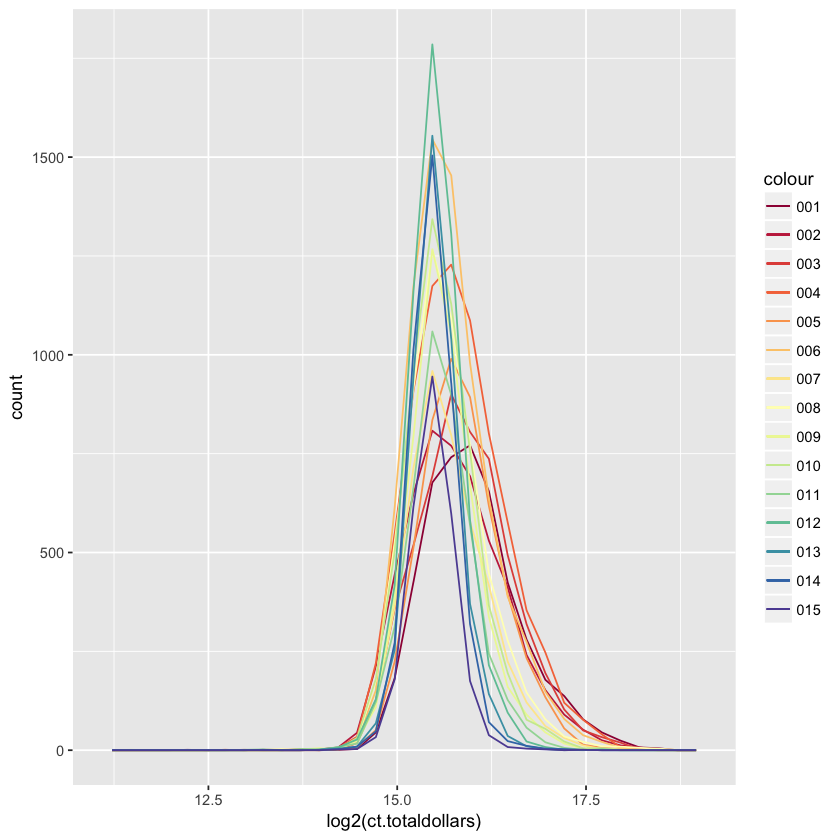

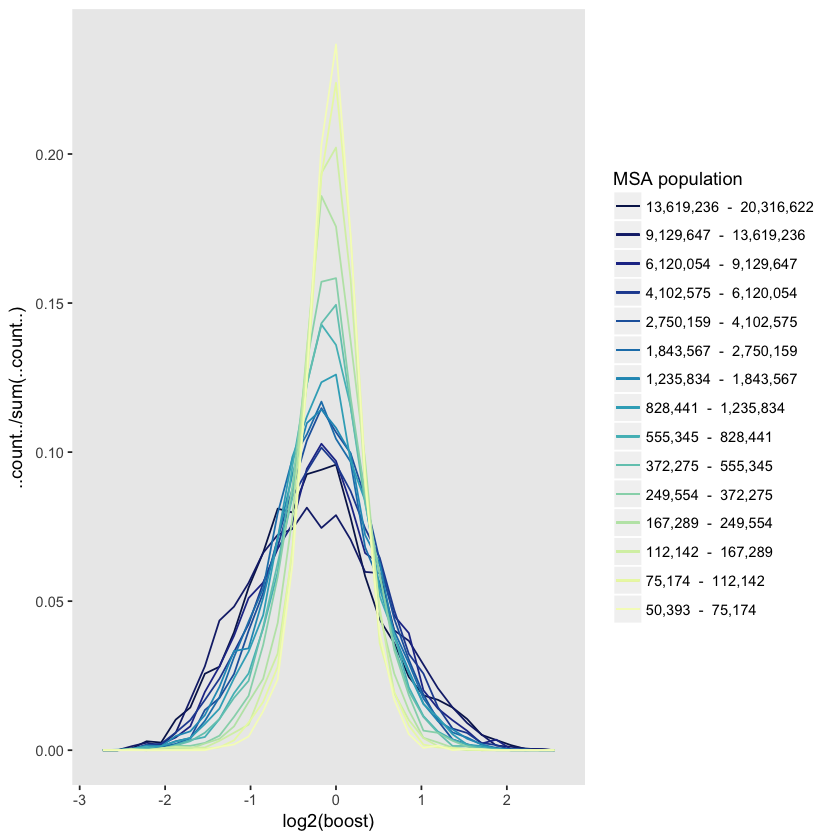

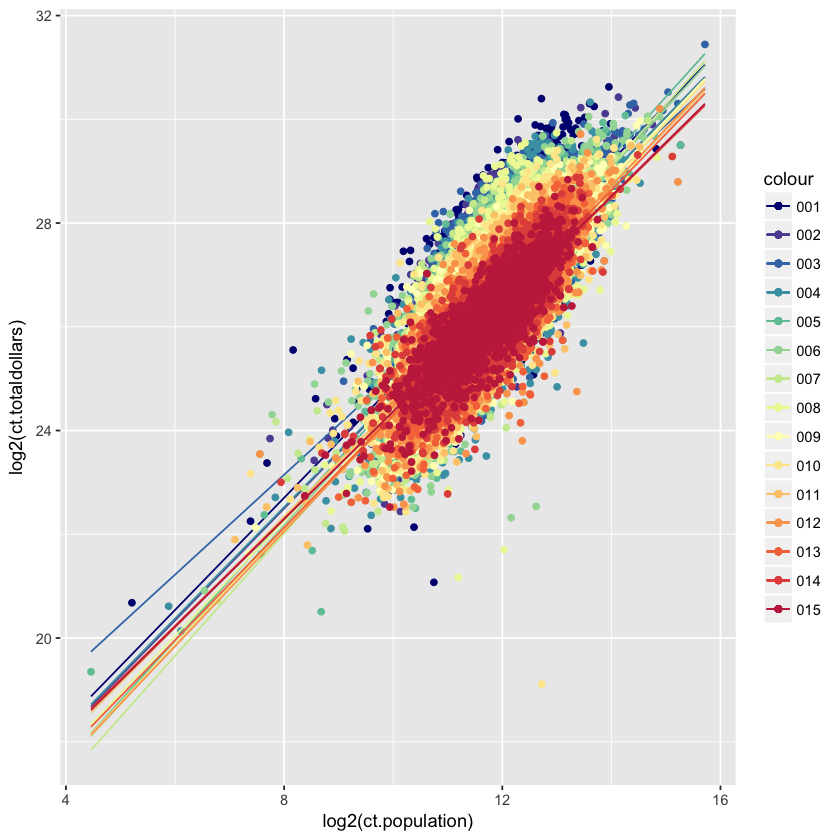

In [79]:
#FLAG
#just confusing

df=ctmsa.df
library(RColorBrewer)
library(entropy)
library(moments)

imin = log2(min(df$pop.sum))
imax = log2(max(df$pop.sum))
i = imax
delta = (imax-imin)/15 #15 MSA bins
j <- ggplot(data=df, aes(log2(ct.population),log2(ct.totaldollars))) #base plot, CT population v CT income, fixed slope of 1
h <- ggplot(data=df, aes(x=log2(ct.totaldollars))) #base plot, income distribution by MSA bin
k <- ggplot(data=df, aes(x=log2(boost))) #base plat, boost distribution by MSA bin
m <- ggplot(data=df, aes(log2(ct.population),log2(ct.totaldollars))) #base plot, CT population v CT income, unfixed

coeff = data.frame(b0=NA,b1=NA,binmin=NA,binmax=NA)
count=1
colcount=1
hist_descriptions = data.frame(bin=NA,entropy=NA,skewness=NA,num_cts=NA)
hist_descriptions2 = data.frame(bin=NA,entropy=NA,skewness=NA,num_cts=NA)
lbls=c()
#i = i + delta
while(i - delta >= imin){
    #i = i - delta
    df_bin = subset(df,log2(df$pop.sum) <= i & log2(df$pop.sum) > i-delta )
    print(nrow(df_bin))
        i = i - delta

    if (nrow(df_bin)>0){
        lm_sum = summary(lm(I(log2(df_bin$ct.totaldollars)-log2(df_bin$ct.population))~1)) #dollars v pop, fixed slope
        lmsum2 = summary(lm(log2(df_bin$ct.totaldollars)~log2(df_bin$ct.population))) #dollars v pop, unfixed slope
        df_bin_normboost=subset(df_bin,log2(df_bin$boost)> -2.5)
        intercept=lm_sum$coefficient[1]
        newi = i + delta
        coeff = rbind(coeff,c(lm_sum$coefficients[1],lm_sum$coefficients[2],i,newi))
        if (count==1){
            br = seq(min(log2(df$ct.totaldollars)),max(log2(df$ct.totaldollars))+1,by=1)
            br2 = seq(min(log2(df$boost)),max(log2(df$boost))+1,by=1)
            #hist(log2(df_bin$ct.totaldollars), breaks=br, include.lowest=TRUE, plot=TRUE)
            freqnew = hist(log2(df_bin$ct.totaldollars), breaks=br, include.lowest=TRUE, plot=FALSE)
            freqnew$countspct=freqnew$counts/sum(freqnew$counts)
#             print("COUNT NOW EQUALS ONE")
#             print(freqnew$counts)

            hist_descriptions=rbind(hist_descriptions,c(count,entropy.empirical(freqnew$counts),skewness(log2(df_bin$ct.totaldollars)),nrow(df_bin)))
            freqnew2 = hist(log2(df_bin$boost), breaks=br2, include.lowest=TRUE, plot=FALSE)
            freqnew2$countspct=freqnew2$counts/sum(freqnew2$counts)
            hist_descriptions2=rbind(hist_descriptions2,c(count,entropy.empirical(freqnew2$counts),skewness(log2(df_bin$boost)),nrow(df_bin)))

        }
        else{
            br = seq(min(log2(df$ct.totaldollars)),max(log2(df$ct.totaldollars))+1,by=1)
            br2 = seq(min(log2(df$boost)),max(log2(df$boost))+1,by=1)
            #hist(log2(df_bin$ct.totaldollars), breaks=br, include.lowest=TRUE, plot=TRUE)
            freqnew = hist(log2(df_bin$ct.totaldollars), breaks=br, include.lowest=TRUE, plot=FALSE)
            freqnew$countspct=freqnew$counts/sum(freqnew$counts)
            hist_descriptions=rbind(hist_descriptions,c(count,entropy.empirical(freqnew$counts),skewness(log2(df_bin$ct.totaldollars)),nrow(df_bin)))
            freqnew2 = hist(log2(df_bin$boost), breaks=br2, include.lowest=TRUE, plot=FALSE)
            freqnew2$countspct=freqnew2$counts/sum(freqnew2$counts)

            hist_descriptions2=rbind(hist_descriptions2,c(count,entropy.empirical(freqnew2$counts),skewness(log2(df_bin$boost)),nrow(df_bin)))
        } 
        if(count<10){
            loop_input=paste('stat_function(fun=function(x) (', intercept, '+', 1,'*x),aes(color=\'00' ,count,'\'))',sep='')
            loop_input4=paste('geom_point(data=df_bin,aes(log2(ct.population),log2(ct.totaldollars),color=\'00' ,count,'\'))',sep='')
            loop_input5=paste('stat_function(fun=function(x) (', lmsum2$coefficients[1], '+', lmsum2$coefficients[2],'*x),aes(color=\'00' ,count,'\'))',sep='')

            loop_input_2=paste('geom_freqpoly(data=df_bin,aes(log2(ct.meandollars), color =\'00', colcount ,'\'))',sep='')
            loop_input_3=paste('geom_freqpoly(data=df_bin_normboost,aes(x=log2(boost), y=..count../sum(..count..), color =\'00', colcount ,'\'))',sep='')

        } else if(count < 100){
            loop_input=paste('stat_function(fun=function(x) (', intercept, '+', 1,'*x),aes(color=\'0' ,count,'\'))',sep='')
            loop_input_2=paste('geom_freqpoly(data=df_bin,aes(log2(ct.meandollars), color =\'0', colcount ,'\'))',sep='')
            loop_input_3=paste('geom_freqpoly(data=df_bin_normboost,aes(x=log2(boost), y=..count../sum(..count..), color =\'0', colcount ,'\'))',sep='')    
            loop_input4=paste('geom_point(data=df_bin,aes(log2(ct.population),log2(ct.totaldollars),color=\'0' ,count,'\'))',sep='')
            loop_input5=paste('stat_function(fun=function(x) (', lmsum2$coefficients[1], '+', lmsum2$coefficients[2],'*x),aes(color=\'0' ,count,'\'))',sep='')

            
        } else{
            loop_input=paste('stat_function(fun=function(x) (', intercept, '+', 1,'*x),aes(color=\'' ,count,'\'))',sep='')            
            loop_input_2=paste('geom_freqpoly(data=df_bin,aes(log2(ct.meandollars), color =\'', colcount ,'\'))',sep='')
            loop_input_3=paste('geom_freqpoly(data=df_bin_normboost,aes(x=log2(boost), y=..count../sum(..count..),color =\'', colcount ,'\'))',sep='')
            loop_input4=paste('geom_point(data=df_bin,aes(log2(ct.population),log2(ct.totaldollars),color=\'' ,count,'\'))',sep='')
            loop_input5=paste('stat_function(fun=function(x) (', lmsum2$coefficients[1], '+', lmsum2$coefficients[2],'*x),aes(color=\'' ,count, '\'))',sep='')

        }
        lbls=c(lbls,paste(format(round(2^(i)),big.mark=','), ' - ', format(round(2^(newi)),big.mark=',')))
        colcount=colcount+1
        j <- j+ eval(parse(text=loop_input4)) + eval(parse(text=loop_input)) 
        h <- h + eval(parse(text=loop_input_2))
        k <- k + eval(parse(text=loop_input_3))  
        m <- m + eval(parse(text=loop_input5)) + eval(parse(text=loop_input4))
    }
    count = count + 1

}
colfunc <- colorRampPalette(brewer.pal(11,"Spectral"))(colcount-1)
    colfunc2 <- colorRampPalette(brewer.pal(9,'YlGnBu'))(colcount)

colfunc3 <- colorRampPalette(c('cadetblue2','navy'))(colcount)

j <- j + scale_color_manual(values=rev(colfunc2),labels=lbls)+ labs(color='MSA population')
h <- h + scale_color_manual(values=colfunc)
k <- k + scale_color_manual(values=rev(colfunc2),labels=lbls) + labs(color='MSA population') + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())# + coord_fixed(ratio=2.5)
m <- m + scale_color_manual(values=rev(c(colfunc,'navy')))
j
h
k
m
#j + coord_cartesian(xlim = c(3, 11),ylim=c(12.5,22.5)) 
#ggsave('~/Desktop/graphs/finalpres/binfixed.png')
#k
#ggsave('~/Desktop/graphs/finalpres/binboostspread.png')
#k.2=k+scale_color_manual(values=colfunc,label=lbls)+ theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+ coord_fixed(ratio=2.5)
#k.2
#ggsave('~/Desktop/graphs/finalpres/binboostspreadrnbw.png')

#j
#m
#ggsave('~/Desktop/graphs/finalpres/bin.unfixed.png')
#xdev.off()
#qplot(hist_descriptions2$bin,hist_descriptions2$entropy)

bin entropy  skewness    num_cts
1 NA        NA          NA   NA   
2  1  1.520121 -0.08085479 4683   
3  2  1.494019 -0.35510733 5151   
4  3  1.468535 -0.20775485 5374   
5  4  1.513571 -0.57602795 7435   
6  5  1.431657 -0.67121422 4975

bin entropy  skewness    num_cts
1 NA        NA          NA   NA   
2  1  1.217908  0.12874832 4683   
3  2  1.242359  0.13476703 5151   
4  3  1.154592  0.04538492 5374   
5  4  1.145994 -0.10311627 7435   
6  5  1.029428 -0.23271197 4975

Warning message:
“Removed 1 rows containing missing values (geom_point).”

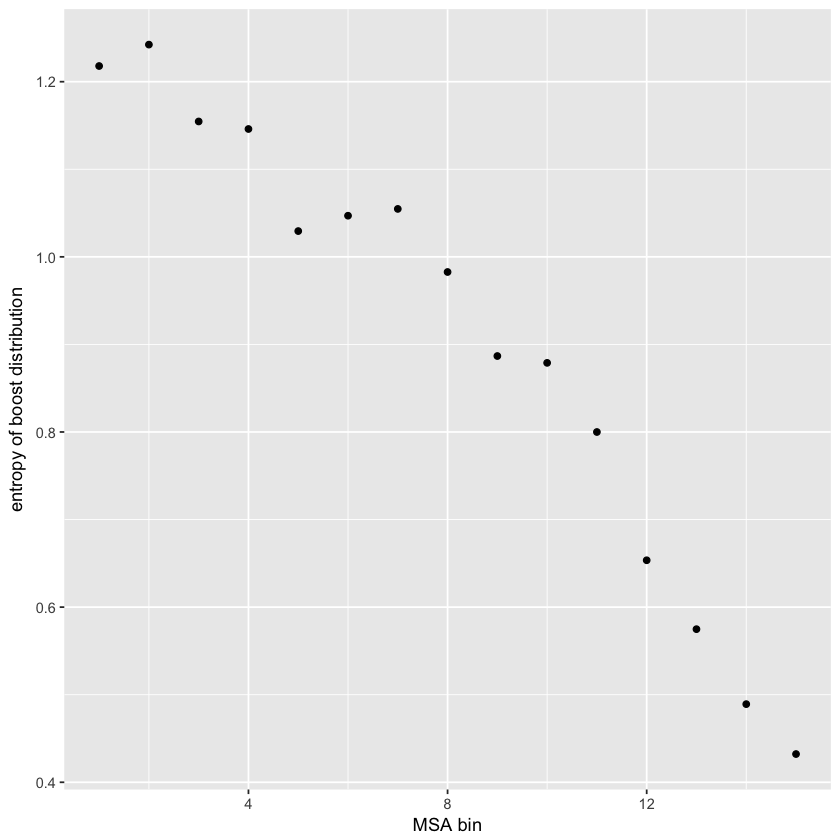

In [82]:
#plot entropy of boost distribution against MSA bin (MSAs get smaller along the X axis)
qplot(hist_descriptions2$bin,hist_descriptions2$entropy) + labs(x='MSA bin',y='entropy of boost distribution')
#ggsave('~/Desktop/graphs/finalpres/boosthistent.png')
#dev.off()

Warning message:
“Removed 1 rows containing missing values (geom_point).”

Warning message:
“Removed 1 rows containing missing values (geom_point).”

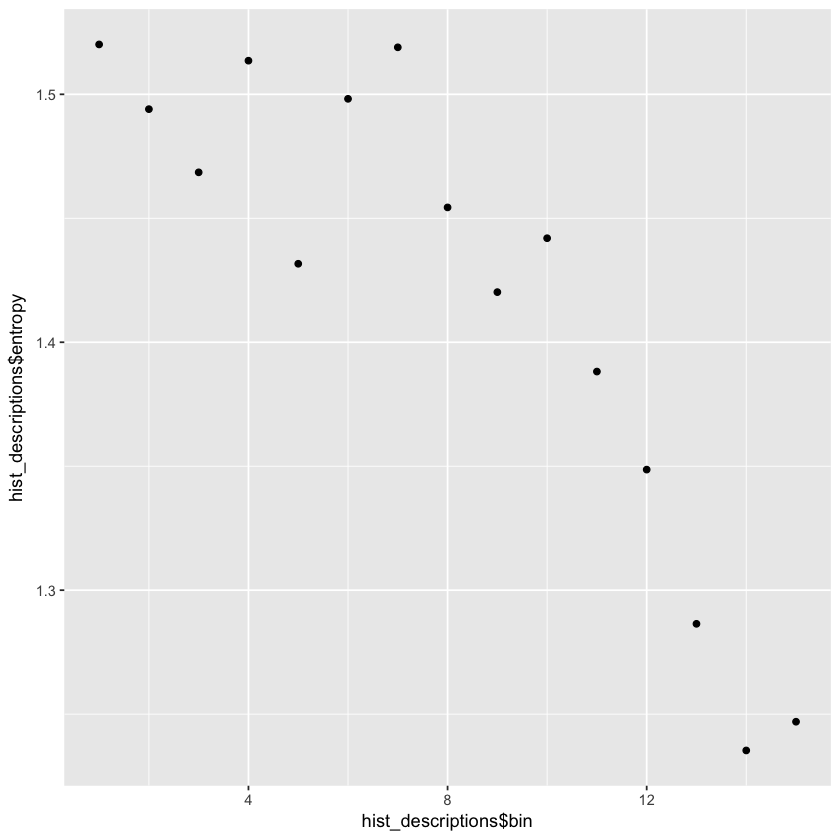

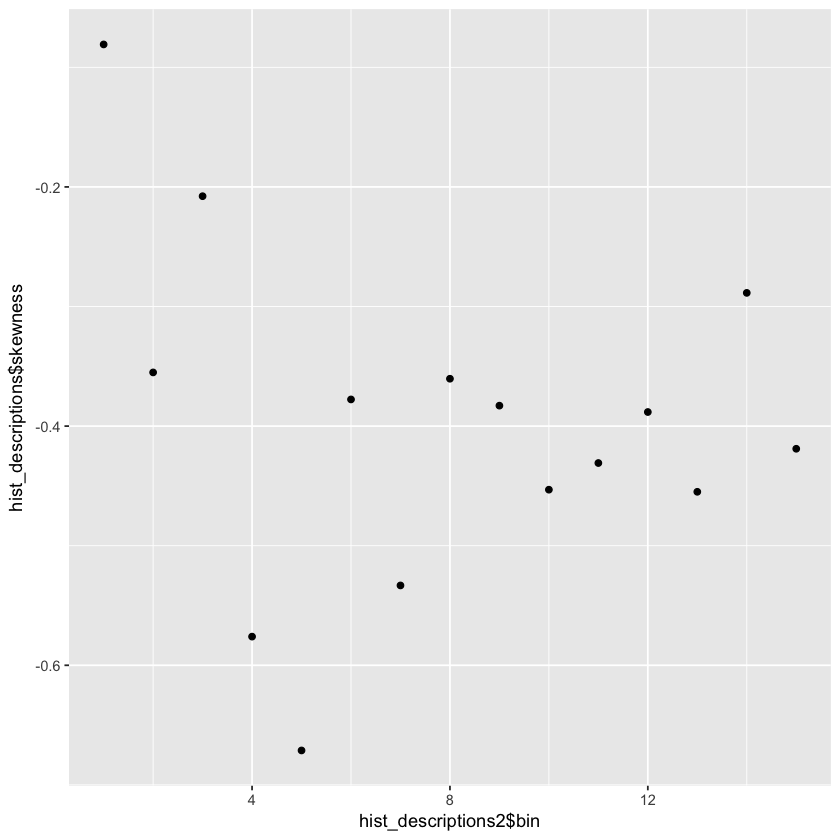

In [84]:
#plot entropy of income distribution against MSA bin (MSAs get smaller along x axis)
qplot(hist_descriptions$bin,hist_descriptions$entropy)

#ggsave('~/Desktop/graphs/finalpres/entropyhist.png')
#dev.off()

#plot skewness of income distribution against MSA bin
qplot(hist_descriptions2$bin,hist_descriptions$skewness)


Call:
lm(formula = log2(sumsMetro$dollars.sum) ~ log2(sumsMetro$pop.sum))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.84075 -0.16771  0.00066  0.17036  0.98391 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             12.959005   0.111793   115.9   <2e-16 ***
log2(sumsMetro$pop.sum)  1.092840   0.006387   171.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2714 on 830 degrees of freedom
Multiple R-squared:  0.9724,	Adjusted R-squared:  0.9724 
F-statistic: 2.928e+04 on 1 and 830 DF,  p-value: < 2.2e-16


Warning message:
“Removed 1 rows containing missing values (geom_point).”

Warning message:
“Removed 1 rows containing missing values (geom_point).”

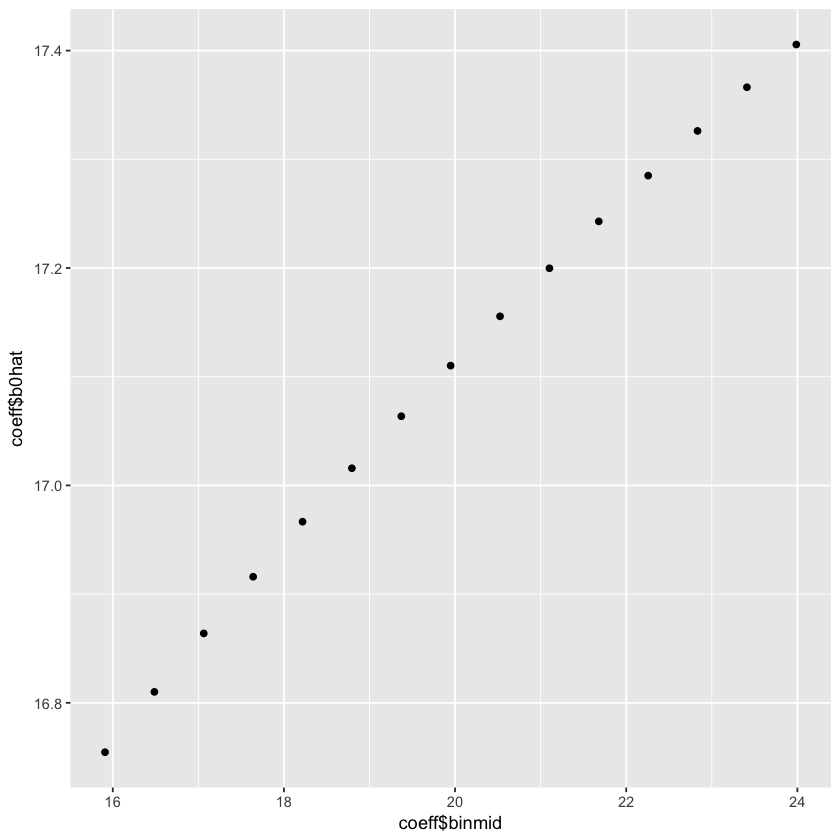

Warning message:
“Removed 1 rows containing missing values (geom_point).”

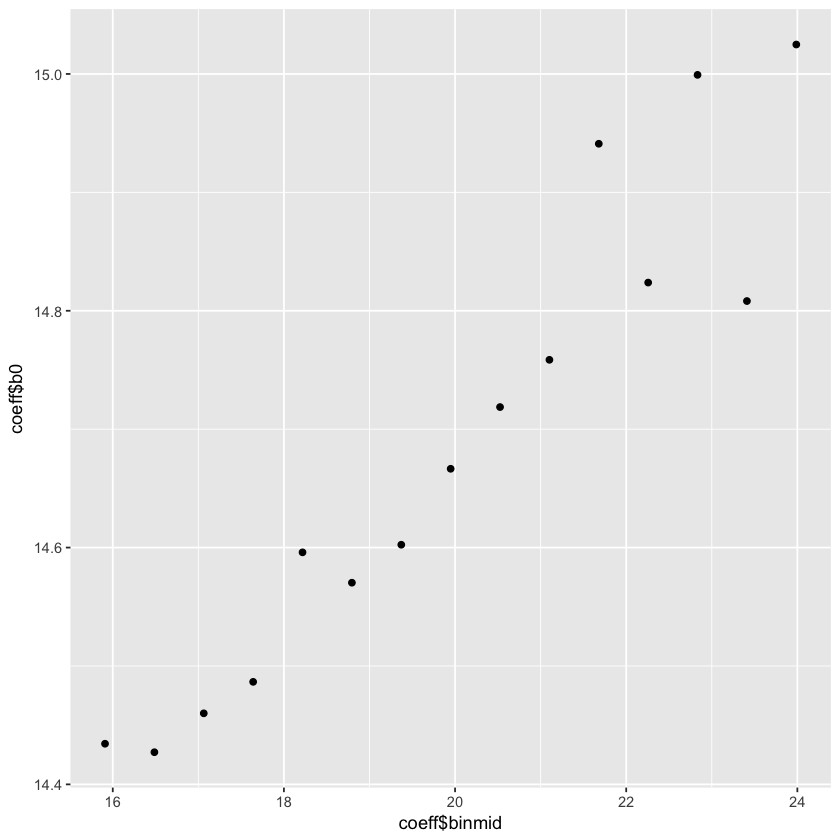

msa   pop.census dollars.census pop.sum dollars.sum
9  33180 27950      321961584      66406    827672445 
11 17260 25254      363639290      58396    729384684 
13 44900 25241      367172000      56637   1122181833 
14 36830 19081      368413760      61095   1189559145 
15 39260 20956      379702400      58539   1240944335 
16 26940 27911      380523080      57276    748060721

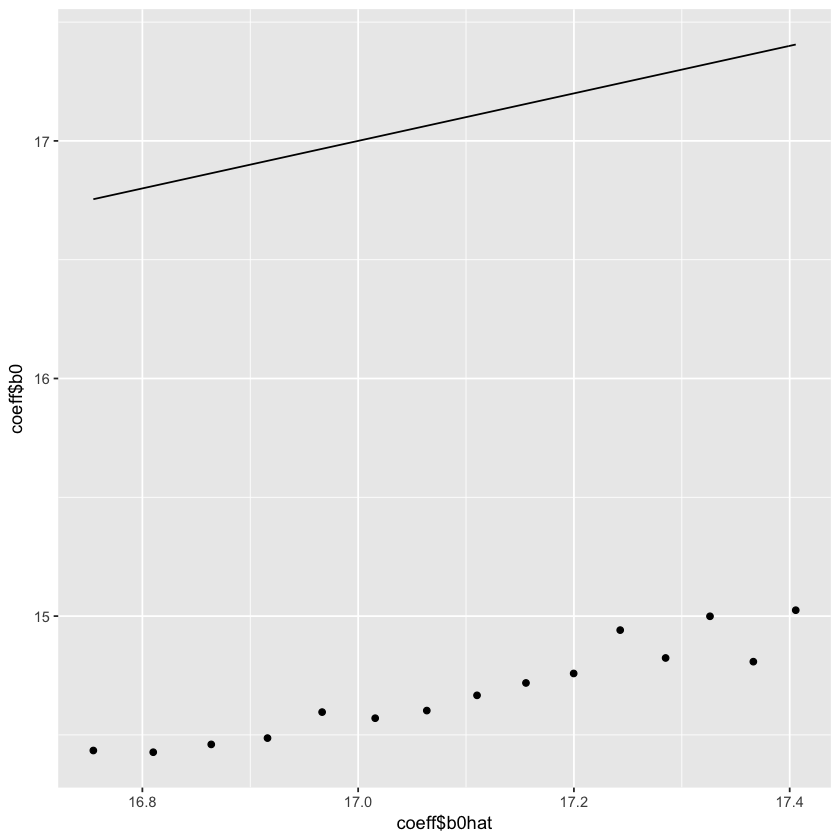

In [85]:
#FLAG
#what r u doin
sumall=summary(lm(log2(sumsMetro$dollars.sum)~log2(sumsMetro$pop.sum)))
sumall
b0_all=sumall$coefficients[1]
b1_all=sumall$coefficients[2]

coeff$binmid=(coeff$binmax+coeff$binmin)/2
coeff$b0hat=(b0_all*((coeff$binmid)^b1_all)/(coeff$binmid))
qplot(coeff$binmid,coeff$b0hat)
qplot(coeff$binmid,coeff$b0)
qplot(coeff$b0hat,coeff$b0)+stat_function(fun=function(x)x)

head(sumsMetro)

### Racial Segregation by Census Tract
using Liz Roberto's Divergence Index

In [89]:
#read in race data
ct.race=read.csv('ct.race.csv',stringsAsFactors=FALSE)
msa.race=read.csv('msa.race.csv',stringsAsFactors=FALSE)

In [90]:
#create database with CTs grouped by MSAs and merged with race data
ct_msa_idkey=read.csv('ct_msa_idkey.csv')
ct.race=merge(ct.race,ct_msa_idkey,by.x='CT',by.y='GEOID')
ct.msa.race=merge(ct.race,msa.race,by.x='msa',by.y='MSA')
ct.msa.race$onerace.x=NULL
ct.msa.race$onerace.y=NULL
ct.msa.race$id_shapefile.y=NULL
ct.msa.race$X=NULL

colnames(ct.msa.race)=c('msa','ct','population.ct','white.im','black.im','am.indian.im','asian.im','pac.islander.im','other.im','multi.im','population.msa','white.m','black.m','am.indian.m','asian.m','pac.islander.m','other.m','multi.m')
ct.msa.race <- data.frame(sapply(ct.msa.race, function(x) as.numeric(as.character(x))))
A = function(x) x/100

#pick out relevant columns
ct.msa.race=ct.msa.race[,c(1,2,3,11,4,5,6,7,8,9,10,12,13,14,15,16,17,18)]
ct.msa.race=cbind(ct.msa.race[1:4], apply(ct.msa.race[5:18],2, A))

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”

In [92]:
#put pacific islander into other category because numbers are so low
ct.msa.race$other.im=ct.msa.race$other.im+ct.msa.race$pac.islander.im
ct.msa.race$other.m=ct.msa.race$other.m+ct.msa.race$pac.islander.m
ct.msa.race$pac.islander.im=NULL
ct.msa.race$pac.islander.m=NULL

#calculate DI--difference between race distribution in the census tract and race distribution in the city as a whole
ct.msa.race$ctDI=(ct.msa.race$white.im*log2(ct.msa.race$white.im/ct.msa.race$white.m)) + (ct.msa.race$black.im*log2(ct.msa.race$black.im/ct.msa.race$black.m)) + (ct.msa.race$am.indian.im*log2(ct.msa.race$am.indian.im/ct.msa.race$am.indian.m))+ (ct.msa.race$asian.im*log2(ct.msa.race$asian.im/ct.msa.race$asian.m))+ (ct.msa.race$other.im*log2(ct.msa.race$other.im/ct.msa.race$other.m))+ (ct.msa.race$multi.im*log2(ct.msa.race$multi.im/ct.msa.race$multi.m)) #+ (ct.msa.race$pac.islander.im*log2(ct.msa.race$pac.islander.im/ct.msa.race$pac.islander.m))

Warning message in eval(expr, envir, enclos):
“NaNs produced”

In [99]:
ct.msa.race=na.omit(ct.msa.race)
#calculate weighted DI for each CT--you will sum these in order to find overall DI for each MSA
ct.msa.race$weightedDI=(ct.msa.race$population.ct/ct.msa.race$population.msa)*ct.msa.race$ctDI
#as said above, sum to find overall DI for each MSA
overall.segregation=aggregate(ct.msa.race$weightedDI, by=list(ct.msa.race$msa),FUN=sum)
colnames(overall.segregation)=c('msa','overallDI')

#create larger dataframe with new measures
ctDI=ct.msa.race[,c('ct','msa','ctDI','population.msa','population.ct')]
boost=ctmsa.df[,c('boost','ct')]
bigdf=merge(ctDI,overall.segregation,by='msa')
bigdf=merge(bigdf,boost,by='ct')

ct         msa   ctDI       population.msa population.ct overallDI boost    
1 1001020100 33860 0.36801263 374536          1912         0.3150088 0.9558940
2 1001020200 33860 0.06454722 374536          2170         0.3150088 0.7636397
3 1001020300 33860 0.19960777 374536          3373         0.3150088 0.9681103
4 1001020400 33860 0.60551985 374536          4386         0.3150088 0.9776833
5 1001020500 33860 0.30177964 374536         10766         0.3150088 1.1213959
6 1001020600 33860 0.18356317 374536          3668         0.3150088 1.1217116
  ctDI.round
1 0.3680    
2 0.0645    
3 0.1996    
4 0.6055    
5 0.3018    
6 0.1836

ctDI_binnedave boost_ave
1 0.00           1.0013649
2 0.01           0.9777996
3 0.02           0.9723577
4 0.03           0.9878681
5 0.04           0.9729762
6 0.05           0.9807813

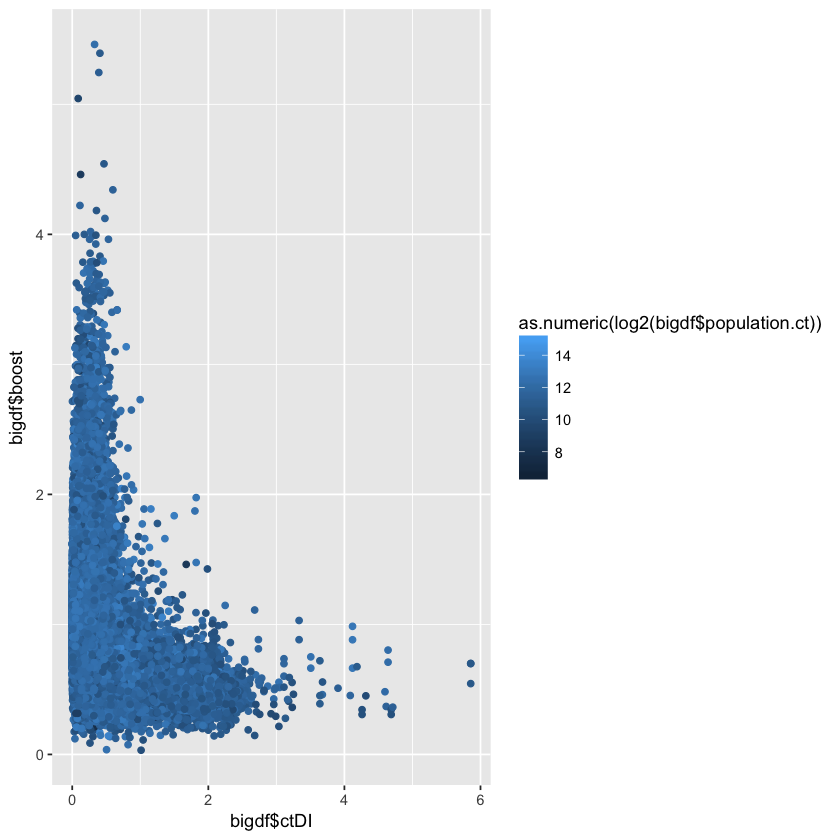

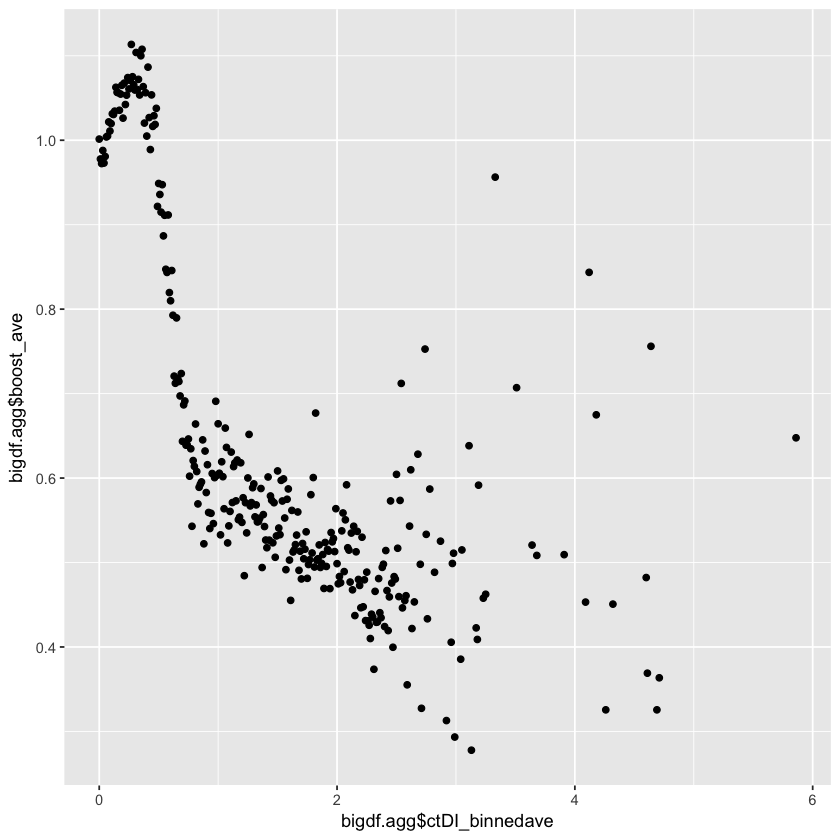

In [104]:
head(bigdf)
#does CT racial segregation affect CT economic performance (boost)?
qplot(bigdf$ctDI,bigdf$boost,color=as.numeric(log2(bigdf$population.ct)))
bigdf$ctDI.round=round(bigdf$ctDI, digits = 4)

#find average boost for bins of Divergence Index
bigdf.agg=aggregate(bigdf$boost,by=list(round(bigdf$ctDI,2)),FUN=mean)
colnames(bigdf.agg)=c("ctDI_binnedave", "boost_ave")
head(bigdf.agg)
#FLAG
#what's happening in this plot
qplot(bigdf.agg$ctDI_binnedave,bigdf.agg$boost_ave)

### NYC Neighborhoods
do functional neighborhoods behave differently than arbitrary census tracts?

In [110]:
#read in census tract income data, merge with Neighborhood Tabulation Area equivalencies
ct_nta=read.csv('ct_nta_equivalency.csv')
idkey=read.csv('idkey.csv')
df_new=merge(idkey,ctdf,by.x='id_census',by.y='GEOID')
df_nta=merge(df_new,ct_nta,by.x='id_shapefile',by.y='CT')
df_nta=na.omit(df_nta)
df_nta$total_dollars=as.numeric(df_nta$total_dollars)
df_nta$total_workers=as.numeric(df_nta$total_workers)
df_nta$mean_dollars=as.numeric(df_nta$mean_dollars)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [111]:
#aggregate data by NTA
df_nta=aggregate(list(df_nta$total_workers,df_nta$total_dollars,df_nta$mean_dollars,df_nta$population),by=list(df_nta$NTA),FUN=sum)            
colnames(df_nta)=c('NTA','total_workers','total_dollars','mean_dollars','population')
dfNTA=df_nta

In [113]:
#compare scaling properties of CTs, NTAs
summary(lm(log2(dfNTA$total_dollars)~log2(dfNTA$population)))
head(ctmsa.df)
df_nyc=subset(ctmsa.df,ctmsa.df$msa==35620)
head(df_nyc)
summary(lm(log2(df_nyc$ct.totaldollars)~log2(df_nyc$ct.population)))



Call:
lm(formula = log2(dfNTA$total_dollars) ~ log2(dfNTA$population))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.40368 -0.43634 -0.08855  0.31253  2.12048 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            14.05309    1.27470   11.03   <2e-16 ***
log2(dfNTA$population)  1.05250    0.08345   12.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7282 on 163 degrees of freedom
  (29 observations deleted due to missingness)
Multiple R-squared:  0.4939,	Adjusted R-squared:  0.4908 
F-statistic: 159.1 on 1 and 163 DF,  p-value: < 2.2e-16


msa   ct          ct.totalworkers ct.meandollars ct.totaldollars
1 10100 46045962200  881            44935           39587735      
2 10100 46013951600 2982            40173          119795886      
3 10100 46013951300 3510            51016          179066160      
4 10100 38081974200 1393            54485           75897605      
5 10100 46089963100 1195            42277           50521015      
6 10100 46013951900 2273            50333          114406909      
  ct.population msa.totalworkers msa.meandollars msa.totaldollars
1 1759          24914            49626           1236382164      
2 4496          24914            49626           1236382164      
3 5819          24914            49626           1236382164      
4 2372          24914            49626           1236382164      
5 2263          24914            49626           1236382164      
6 3677          24914            49626           1236382164      
  msa.population pop.census dollars.census pop.sum dollars.sum boost    
1 42078          42078      1236382164     60151   1701373208  0.7956793
2 42078          42078      1236382164     60151   1701373208  0.9420173
3 42078          42078      1236382164     60151   1701373208  1.0879487
4 42078          42078      1236382164     60151   1701373208  1.1312449
5 42078          42078      1236382164     60151   1701373208  0.7892794
6 42078          42078      1236382164     60151   1701373208  1.1000233

msa   ct          ct.totalworkers ct.meandollars ct.totaldollars
45176 35620 36081076901 2583            90924          234856692      
45177 35620 36059520900 2651            79473          210682923      
45178 35620 36061015601 4284            90082          385911288      
45179 35620 36059414501 2959            64886          191997674      
45180 35620 36005027900 3873            49556          191930388      
45181 35620 36059414502 2583            69430          179337690      
      ct.population msa.totalworkers msa.meandollars msa.totaldollars
45176 4172          10410096         76066           7.91854e+11     
45177 4615          10410096         76066           7.91854e+11     
45178 5408          10410096         76066           7.91854e+11     
45179 5242          10410096         76066           7.91854e+11     
45180 6809          10410096         76066           7.91854e+11     
45181 4325          10410096         76066           7.91854e+11     
      msa.population pop.census dollars.census pop.sum  dollars.sum  boost    
45176 19979950       19979950   7.91854e+11    20316622 803150716925 1.4240102
45177 19979950       19979950   7.91854e+11    20316622 803150716925 1.1548141
45178 19979950       19979950   7.91854e+11    20316622 803150716925 1.8051166
45179 19979950       19979950   7.91854e+11    20316622 803150716925 0.9265170
45180 19979950       19979950   7.91854e+11    20316622 803150716925 0.7130416
45181 19979950       19979950   7.91854e+11    20316622 803150716925 1.0489141


Call:
lm(formula = log2(df_nyc$ct.totaldollars) ~ log2(df_nyc$ct.population))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6003 -0.5074 -0.0055  0.4569  2.6708 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                14.05062    0.19305   72.78   <2e-16 ***
log2(df_nyc$ct.population)  1.08166    0.01615   66.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7678 on 4681 degrees of freedom
Multiple R-squared:  0.4893,	Adjusted R-squared:  0.4891 
F-statistic:  4484 on 1 and 4681 DF,  p-value: < 2.2e-16


Warning message:
“Removed 29 rows containing missing values (geom_point).”


	Pearson's product-moment correlation

data:  log2(dfNTA$population) and (log2(dfNTA$total_dollars))
t = 12.612, df = 163, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6161570 0.7726076
sample estimates:
      cor 
0.7027816 


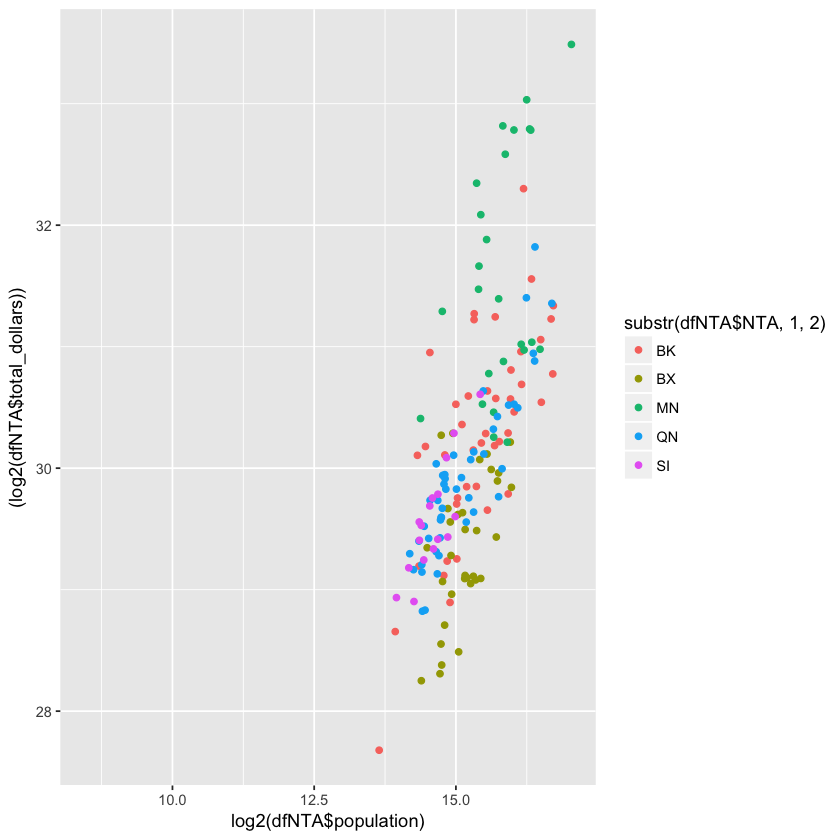

In [115]:
qplot(log2(dfNTA$population),(log2(dfNTA$total_dollars)),color=substr(dfNTA$NTA,1,2))
cor.test(log2(dfNTA$population),(log2(dfNTA$total_dollars)))

### Subway Traffic Data

In [116]:
#compare disporportional subway traffic to disporportional income--are they correlated?
subboost=read.csv('subwaynta.csv')
head(subboost)
subboostnta=merge(dfNTA,subboost,by.x='NTA',by.y='nta')
head(subboostnta)
subboostnta=na.omit(subboostnta)
subboostnta$flowboost=subboostnta$total/((subboostnta$population/sum(subboostnta$population))*sum(subboostnta$total))
subboostnta$dollarboost=subboostnta$total_dollars/((subboostnta$population/sum(subboostnta$population))*sum(subboostnta$total_dollars))

mean(subboostnta$flowboost)
mean(subboostnta$dollarboost)

X nta  entries    exits      total     
1 1 BK09  331000066   48909564  379909630
2 2 BK17  212356414   17402876  229759290
3 3 BK19  247373235   17704531  265077766
4 4 BK21    8344322    2148822   10493144
5 5 BK23   10263433   16611457   26874890
6 6 BK25 1580708987 1590569924 3171278911

NTA  total_workers total_dollars mean_dollars population X entries   
1 BK09 15109         2076864678     823011      23839      1  331000066
2 BK17 30654         1880005616    1243652      64254      2  212356414
3 BK19 14903          905626091     515623      33423      3  247373235
4 BK21  8950                 NA         NA      25336      4    8344322
5 BK23  7689          422633726     212029      15606      5   10263433
6 BK25 19845         1239663798    1024353      44738      6 1580708987
  exits      total     
1   48909564  379909630
2   17402876  229759290
3   17704531  265077766
4    2148822   10493144
5   16611457   26874890
6 1590569924 3171278911

[1] 0.9938643

[1] 0.9681562

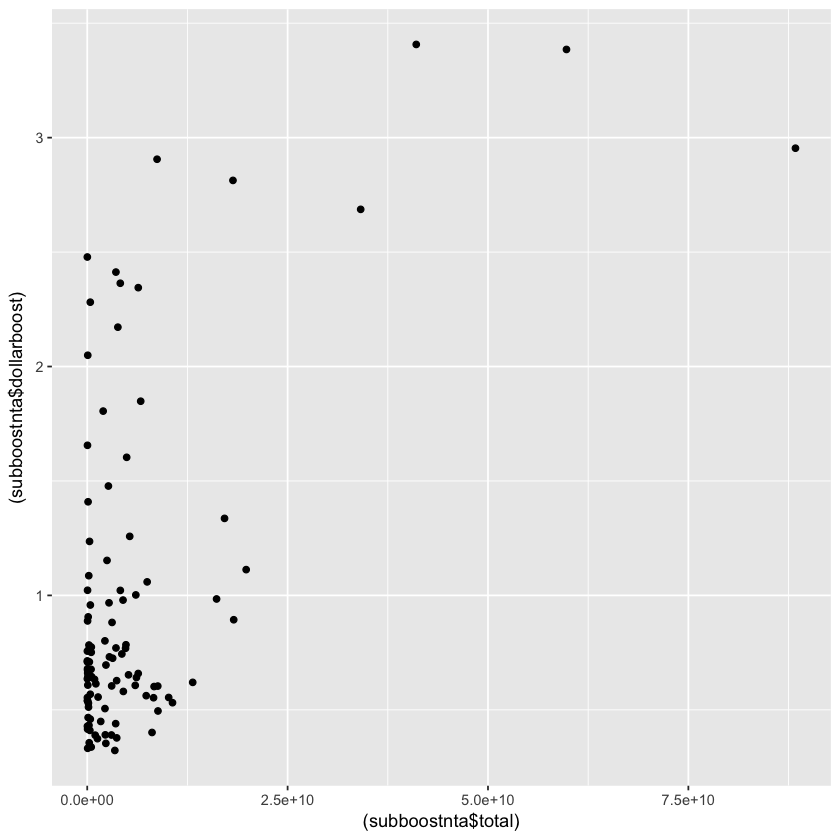

In [117]:
qplot((subboostnta$total),(subboostnta$dollarboost))

### Citi Bike traffic boost

In [118]:
#same as above but for CitiBike traffic
bikein=read.csv('nyct2010_17b/bikeinflow')
boost.idkey=merge(ctmsa.df,idkey,by.x='ct',by.y='id_census')
head(boost.idkey)
head(bikein)
bikeboost=merge(boost.idkey,bikein,by.x='id_shapefile',by.y='inflow.District')
head(bikeboost)

ct         msa   ct.totalworkers ct.meandollars ct.totaldollars ct.population
1 3.6005e+10 35620 2450            46689          114388050       5403         
2 3.6005e+10 35620 2961            55794          165206034       5915         
3 3.6005e+10 35620 2375            44951          106758625       5879         
4 3.6005e+10 35620 1296            39502           51194592       2591         
5 3.6005e+10 35620 2752            35995           99058240       8516         
6 3.6005e+10 35620 1320            31468           41537760       4774         
  msa.totalworkers msa.meandollars msa.totaldollars msa.population pop.census
1 10410096         76066           7.91854e+11      19979950       19979950  
2 10410096         76066           7.91854e+11      19979950       19979950  
3 10410096         76066           7.91854e+11      19979950       19979950  
4 10410096         76066           7.91854e+11      19979950       19979950  
5 10410096         76066           7.91854e+11      19979950       19979950  
6 10410096         76066           7.91854e+11      19979950       19979950  
  dollars.census pop.sum  dollars.sum  boost     id_shapefile
1 7.91854e+11    20316622 803150716925 0.5355501 2000200     
2 7.91854e+11    20316622 803150716925 0.7065219 2000400     
3 7.91854e+11    20316622 803150716925 0.4593608 2001600     
4 7.91854e+11    20316622 803150716925 0.4998171 2001900     
5 7.91854e+11    20316622 803150716925 0.2942452 2002000     
6 7.91854e+11    20316622 803150716925 0.2200975 2002300

X inflow.District inflow.Inflow
1 1 1000202         123802       
2 2 1000500           4558       
3 3 1000600         157947       
4 4 1000700         345332       
5 5 1000800          74830       
6 6 1000900         144504

id_shapefile ct         msa   ct.totalworkers ct.meandollars ct.totaldollars
1 1000202      3.6061e+10 35620 3141             62573         196541793      
2 1000600      3.6061e+10 35620 4390             36851         161775890      
3 1000700      3.6061e+10 35620 6779            129163         875595977      
4 1000800      3.6061e+10 35620 4435             41186         182659910      
5 1000900      3.6061e+10 35620 1209            167298         202263282      
6 1001002      3.6061e+10 35620 2098             28844          60514712      
  ct.population msa.totalworkers msa.meandollars msa.totaldollars
1  7768         10410096         76066           7.91854e+11     
2 12554         10410096         76066           7.91854e+11     
3  8794         10410096         76066           7.91854e+11     
4  9465         10410096         76066           7.91854e+11     
5  1626         10410096         76066           7.91854e+11     
6  6051         10410096         76066           7.91854e+11     
  msa.population pop.census dollars.census pop.sum  dollars.sum  boost     X
1 19979950       19979950   7.91854e+11    20316622 803150716925 0.6400297 1
2 19979950       19979950   7.91854e+11    20316622 803150716925 0.3259764 3
3 19979950       19979950   7.91854e+11    20316622 803150716925 2.5186728 4
4 19979950       19979950   7.91854e+11    20316622 803150716925 0.4881767 5
5 19979950       19979950   7.91854e+11    20316622 803150716925 3.1466682 6
6 19979950       19979950   7.91854e+11    20316622 803150716925 0.2529812 7
  inflow.Inflow
1 123802       
2 157947       
3 345332       
4  74830       
5 144504       
6  37878

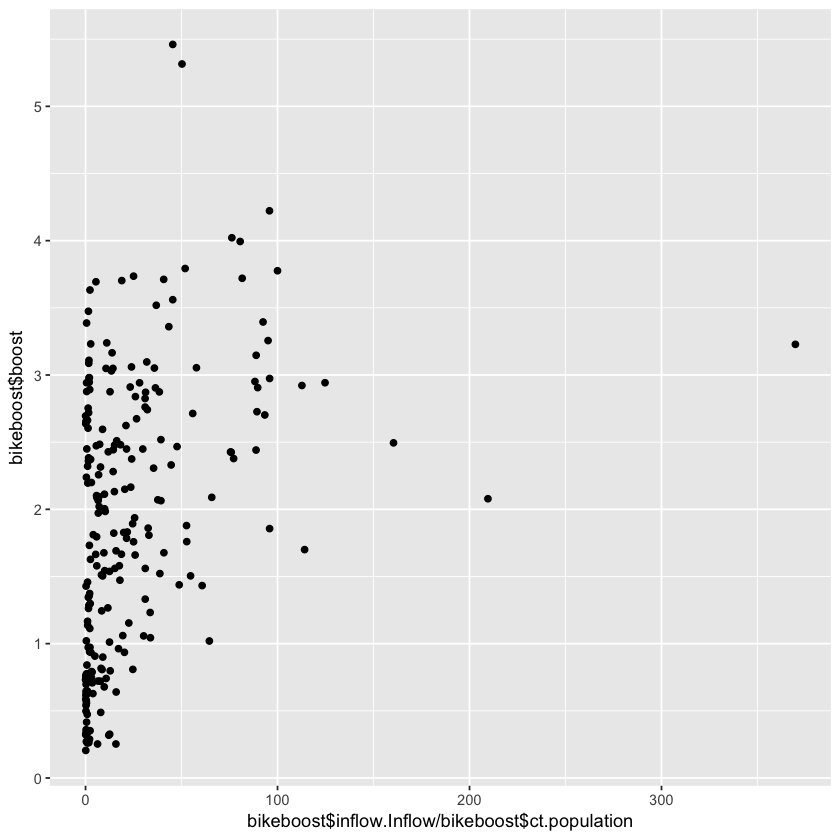

In [119]:
qplot(bikeboost$inflow.Inflow/bikeboost$ct.population,bikeboost$boost)

## Assorted Graphics

In [ ]:
#msa scale line
msa.df=ctmsa.df[,c('msa','msa.totalworkers','msa.meandollars','pop.sum','dollars.sum')]
msa.df=msa.df[!duplicated(msa.df), ]
msa.df=subset(msa.df,msa.df$pop.sum > 100000)
lm.msa=summary(lm(log2(msa.df$dollars.sum)~log2(msa.df$pop.sum)))
lm.msa2=lm(log2(msa.df$dollars.sum)~log2(msa.df$pop.sum))
lm.msa$coefficients[2]-confint(lm.msa2)[2]
lm.msa
diff=(lm.msa$coefficients[1]+lm.msa$coefficients[2]*min(log2(msa.df$pop.sum)))-min(log2(msa.df$pop.sum))
diff
nrow(msa.df)
# qplot(log2(msa.df$pop.sum),log2(msa.df$dollars.sum))
# ggsave('~/Desktop/graphs/finalpres/msascale.png')
  qplot(log2(msa.df$pop.sum),log2(msa.df$dollars.sum))+
 stat_function(fun=function(x)lm.msa$coefficients[1]+lm.msa$coefficients[2]*x,col='#41b6c4',alpha=1,size=1) +
  stat_function(fun=function(x)x+(diff),col='gray',alpha=1,linetype='dashed',size=1) +
labs(x='log2(MSA population)',y='log2(MSA income)')
  ggsave('~/Desktop/graphs/finalpres/msascaleline.png')
  dev.off()

In [180]:
max(bikeboost$pop.census)

[1] 19979950